# Notebook for analyzing data from our S-index validation work using 49M+ real world datasets

## Import

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import to_rgba
from scipy import stats
import math
import textwrap

In [2]:
import seaborn as sns
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        # Typography
        "font.size": 10,          
        "axes.titlesize": 16,     
        "axes.titleweight": "bold",
        "axes.labelsize": 14,      
        "xtick.labelsize": 12,     
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        
        # Spines and Ticks
        "axes.spines.top": False,    
        "axes.spines.right": False,  
        "axes.linewidth": 0.8,      
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out", 
        "ytick.direction": "out",
    }
)
# Wong Palette (optimized for color-blindness)
color_palette = [
    '#009E73', # Green
    '#0072B2', # Blue
    '#D55E00', # Vermillion (Orange-Red)
    '#56B4E9', # Sky Blue
    '#F0E442', # Yellow
    '#CC79A7'  # Reddish Purple
]
sns.set_palette(color_palette)

## Helper functions

In [3]:
# Function to show numbers as 10M, 300k, etc. for ease of reading
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.0f}k'.replace('.0k', 'k')
    return str(int(value))
    
# Function to wrap text after 3 words
def wrap_labels(text, max_words=3, char_limit=25):
    lowercase_words = {'for', 'of', 'the', 'and', 'in', 'on', 'at', 'to', 'a', 'an', 'by'}
    
    # 2. Pre-process: Capitalize and Format
    words = text.split()
    processed_words = []
    
    for i, w in enumerate(words):
        # Acronyms (Parentheses) -> UPPER
        if '(' in w or ')' in w:
            processed_words.append(w.upper())
        # First word -> Capitalize
        elif i == 0:
            processed_words.append(w.capitalize())
        # Stop words -> lower
        elif w.lower() in lowercase_words:
            processed_words.append(w.lower())
        # Default -> Capitalize
        else:
            processed_words.append(w.capitalize())

    # 3. Grouping Logic (Hybrid: Count AND Length)
    lines = []
    current_line = []
    current_length = 0

    for word in processed_words:
        # Calculate length if we were to add this word
        # (len(word) + 1 space if the line isn't empty)
        added_length = len(word) + (1 if current_line else 0)
        
        # Check conditions to WRAP:
        # A. We hit the max word count (e.g., 3)
        # B. Adding this word would exceed the char_limit (and line isn't empty)
        if (len(current_line) >= max_words) or \
           (current_line and (current_length + added_length > char_limit)):
            
            # "Commit" the current line
            lines.append(" ".join(current_line))
            
            # Start a new line with the current word
            current_line = [word]
            current_length = len(word)
        else:
            # Add to current line
            current_line.append(word)
            current_length += added_length

    # Append any remaining words
    if current_line:
        lines.append(" ".join(current_line))

    return "\n".join(lines)

## DuckDB database file path

In [4]:
# See README for instructions to download this file
dataset_db = r"C:\Users\BPatel\Documents\dataset_index\dataset_reports.duckdb"

## Overview of datasets used for the analysis

Overview of the datasetes used for our real world validation

### Preview table

In [5]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM metadata
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pub_ts,pubyear,creators,title,source
0,10.15156/bio/sh3578074.08fu,2021-01-01,2021,"[{""name"":""Kõljalg, Urmas"",""name_type"":""Persona...",SH3578074.08FU,datacite
1,10.15156/bio/sh3578075.08fu,2021-01-01,2021,"[{""name"":""Kõljalg, Urmas"",""name_type"":""Persona...",SH3578075.08FU,datacite
2,10.5281/zenodo.5152863,2021-01-01,2021,"[{""name"":""Roth, Marco Pascal"",""identifiers"":[""...",Seismicity catalog of hydraulic-fracturing-ind...,datacite


### Number of datasets

In [6]:
# Data
con = duckdb.connect(dataset_db)

query = """
SELECT 
    COALESCE(source, 'Total') AS source,
    COUNT(*) AS dataset_count
FROM metadata
GROUP BY ROLLUP(source)
ORDER BY (source IS NULL) ASC, dataset_count DESC;
"""

df_dataset_source = con.execute(query).df()
con.close()

# Display
print("Number of datasets by source:")
display(df_dataset_source.style.format({'dataset_count': '{:,}'}))

Number of datasets by source:


,source,dataset_count
0,datacite,"49,009,522"
1,emdb,"51,645"
2,Total,"49,061,167"


### Distribution of datasets by publication years

In [7]:
# Data
con = duckdb.connect(dataset_db)

query = """
SELECT 
    pubyear, 
    COUNT(*) AS dataset_count
FROM metadata
WHERE pubyear IS NOT NULL
GROUP BY pubyear
ORDER BY pubyear
"""

df_dataset_pub_year = con.execute(query).df()
con.close()
display(df_dataset_pub_year.head())

,pubyear,dataset_count
0,1950,97
1,1951,96
2,1952,103
3,1953,349
4,1954,309


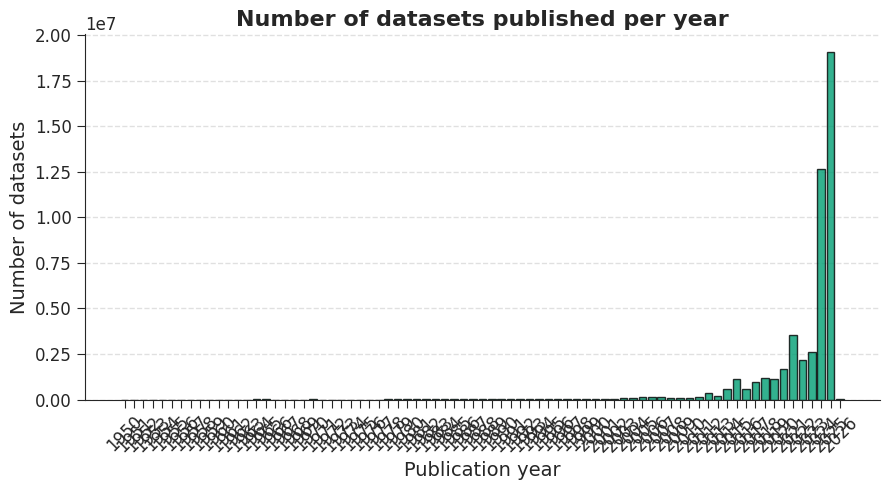

In [8]:
# Plot dataset count vs publication year
plt.figure(figsize=(9, 5))
plt.bar(df_dataset_pub_year['pubyear'].astype(str), df_dataset_pub_year['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.8)

# Formatting
plt.title('Number of datasets published per year')
plt.xlabel('Publication year')
plt.ylabel('Number of datasets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save
plt.tight_layout()
plt.show()

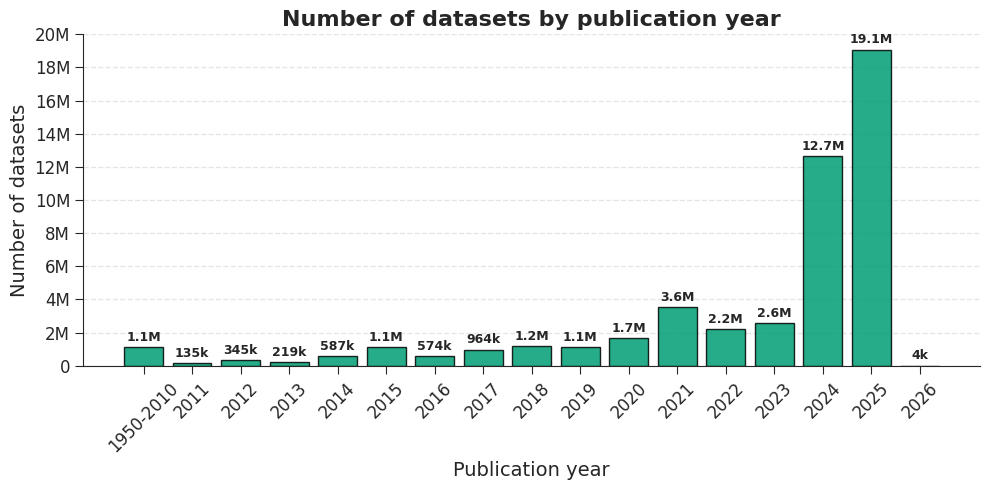

In [9]:
# Plot dataset count vs pubyear regroup 1950 to 2010 count
df_dataset_pub_year['year_bucket'] = np.where(df_dataset_pub_year['pubyear'] <= 2010, '1950-2010', df_dataset_pub_year['pubyear'].astype(str))
plot_df = df_dataset_pub_year.groupby('year_bucket').agg({'dataset_count': 'sum', 'pubyear': 'min'}).sort_values('pubyear').reset_index()
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(plot_df['year_bucket'], plot_df['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.85)

# Formatting
plt.title('Number of datasets by publication year')
ax.set_ylabel('Number of datasets')
ax.set_xlabel('Publication year')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
    
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (ax.get_ylim()[1] * 0.01),
            format_k_m(height), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Format y axis labels to show M (more clean)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1e6)}M' if x != 0 else '0'))
ax.set_yticks(np.arange(0, 21_000_000, 2_000_000))
ax.set_ylim(0, 20_000_000)

sns.despine()

# Save
plt.tight_layout()
plt.show()

### Number of data repositories represented in DataCite datasets

In [10]:
df_repo = pd.read_csv('input/publisher_counts.csv')
print(f"Number of data repositories represented in DataCite datasets: {len(df_repo):,}")

Number of data repositories represented in DataCite datasets: 17,306


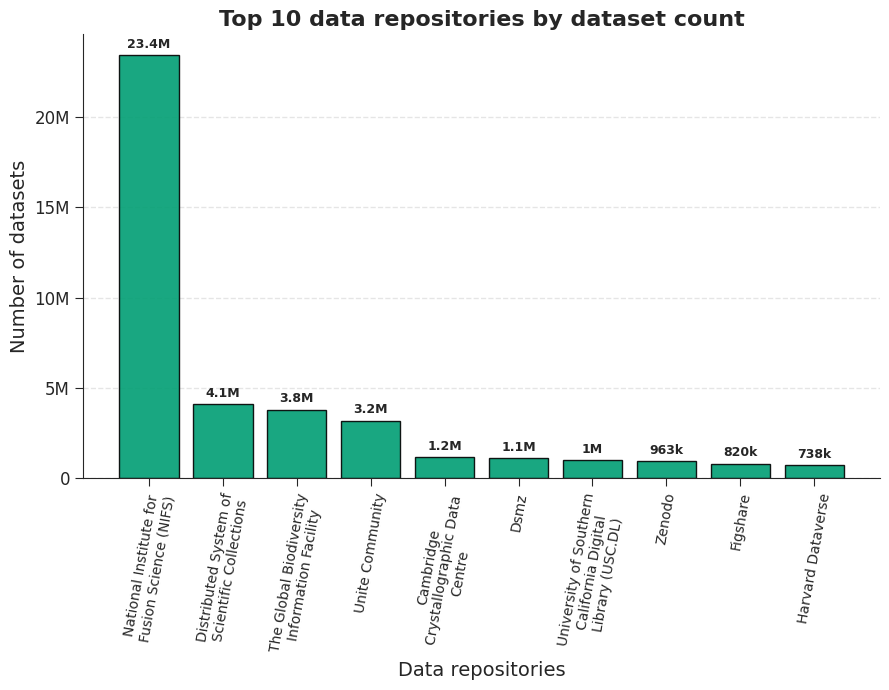

In [11]:
# Prepare Data
top_10 = df_repo.sort_values(by='Dataset Count', ascending=False).head(10)

# Apply wrapping to the labels
top_10['Wrapped_Publisher'] = top_10['Publisher'].apply(lambda x: wrap_labels(str(x)))

# Plot
plt.figure(figsize=(9, 7))
bars1 = plt.bar(top_10['Wrapped_Publisher'], top_10['Dataset Count'], 
                color=color_palette[0], alpha=0.9, edgecolor='black')

# Styling
plt.ylabel('Number of datasets')  # Swapped label: Y is count, X is Publisher
plt.xlabel('Data repositories')
plt.title('Top 10 data repositories by dataset count')
ax = plt.gca()
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)


plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=80, fontsize=10) 

max_h = top_10['Dataset Count'].max()

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max_h * 0.01),  
        format_k_m(height),           
        ha='center', 
        va='bottom', 
        fontweight='bold', 
        fontsize=9
    )

plt.tight_layout()
plt.show()

### Diversity of data Licenses

In [12]:
license_data = r"input\license_counts.csv"
df_license = pd.read_csv(license_data)

# 2. Define the licenses you want to include
target_licenses = [
    "LHD Data Usage and Publication Agreement", 
    "Creative Commons Zero v1.0 Universal", 
    "Creative Commons Attribution 4.0 International", 
    "Creative Commons Attribution Non Commercial 4.0 International", 
    "Data access is restricted (moratorium, sensitive data, license constraints)", 
    "Restricted Access", 
    "Custom terms specific to this dataset"
]

# 3. Filter the dataframe
filtered_df = df_license[df_license['License'].isin(target_licenses)]
display(filtered_df)

,License,Count
1,LHD Data Usage and Publication Agreement,23388951
3,Creative Commons Zero v1.0 Universal,4856568
4,Creative Commons Attribution 4.0 International,3551321
5,Creative Commons Attribution Non Commercial 4....,3463011
14,Custom terms specific to this dataset,74849
19,"Data access is restricted (moratorium, sensiti...",45660
28,Restricted Access,20151


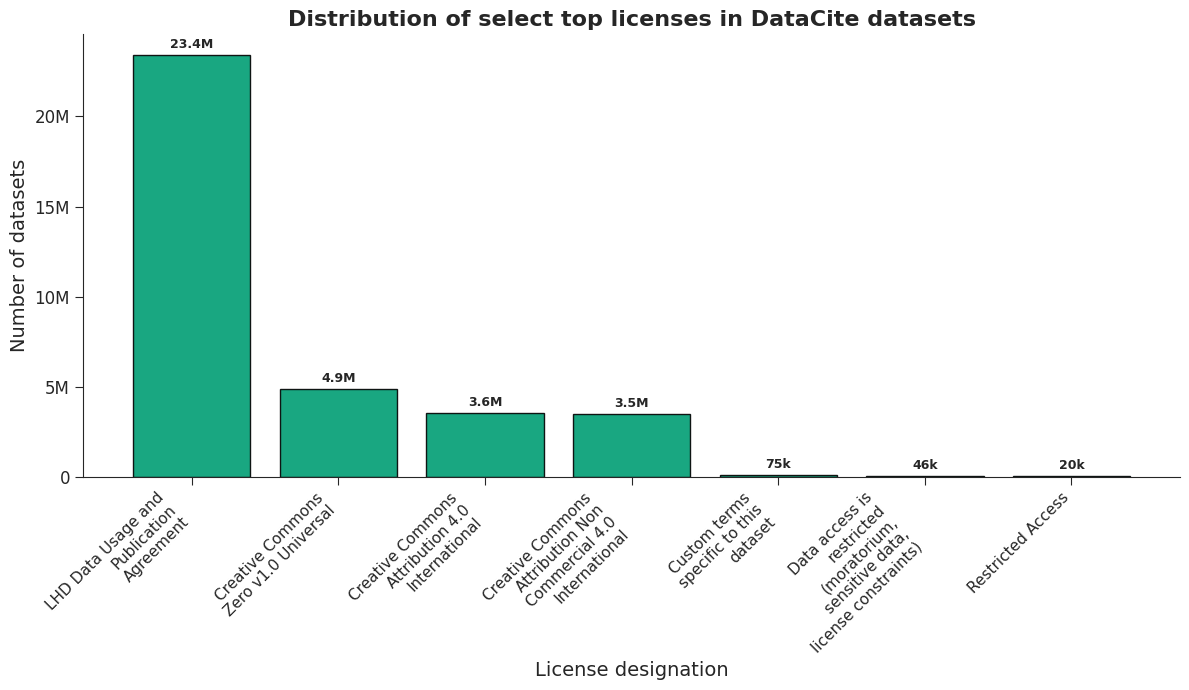

In [13]:
# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(filtered_df['License'], filtered_df['Count'], color=color_palette[0], edgecolor='black', alpha=0.9)

# Helper function to wrap long labels for readability
labels = [textwrap.fill(label, 20) for label in filtered_df['License']]
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=11)

plt.title('Distribution of select top licenses in DataCite datasets')
plt.ylabel('Number of datasets')
plt.xlabel('License designation')
ax = plt.gca()
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)
# Adding value labels on top of bars
max_h = filtered_df['Count'].max()
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max_h * 0.01),  
        format_k_m(height),           
        ha='center', 
        va='bottom', 
        fontweight='bold', 
        fontsize=9
    )

plt.tight_layout()
plt.show()

### Combined plot

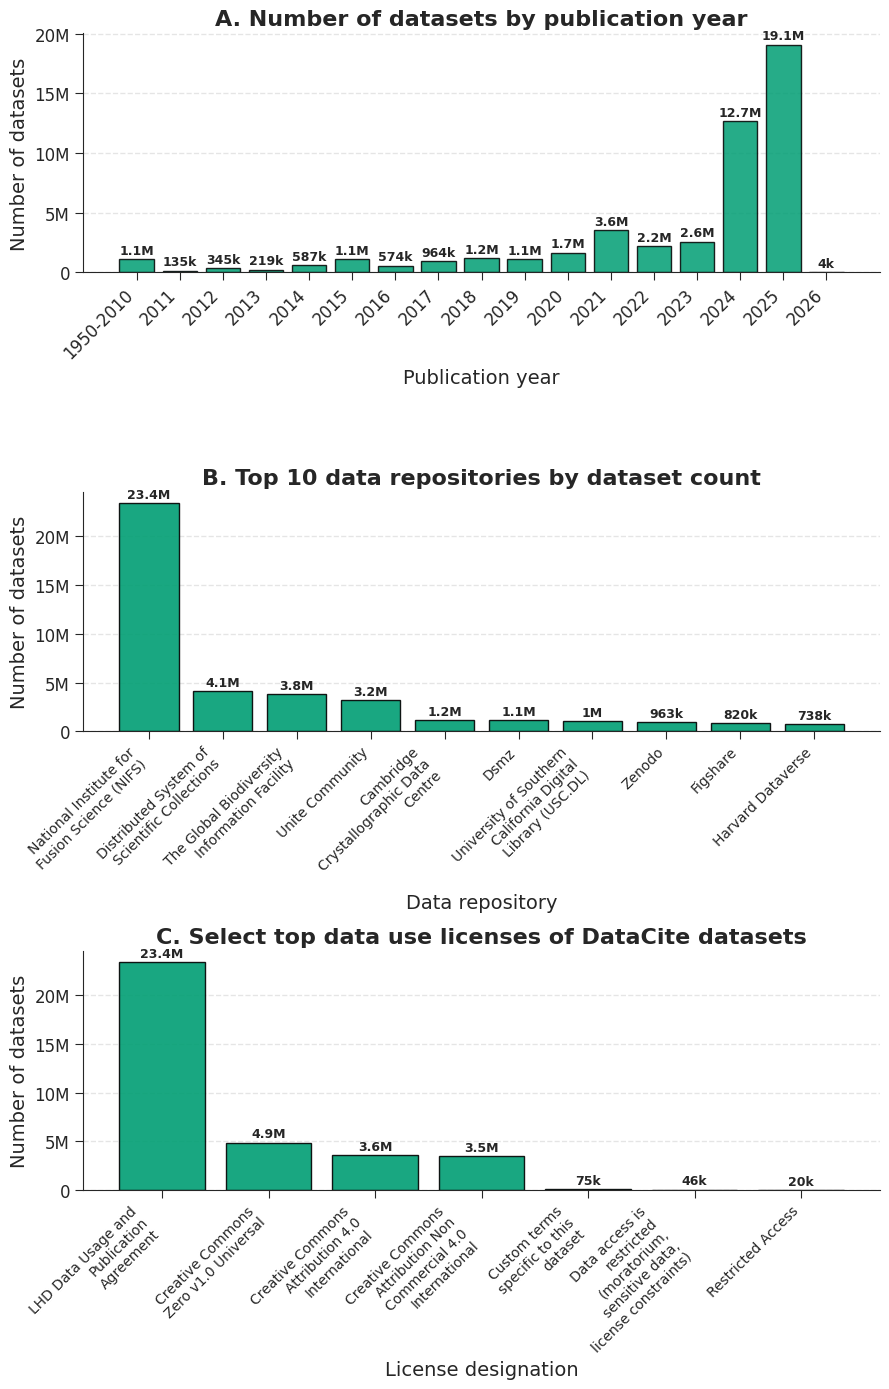

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 14))

# Plot dataset count vs pubyear regroup 1950 to 2010 count
df_dataset_pub_year['year_bucket'] = np.where(df_dataset_pub_year['pubyear'] <= 2010, '1950-2010', df_dataset_pub_year['pubyear'].astype(str))
plot_df = df_dataset_pub_year.groupby('year_bucket').agg({'dataset_count': 'sum', 'pubyear': 'min'}).sort_values('pubyear').reset_index()

bars = ax1.bar(plot_df['year_bucket'], plot_df['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.85)

# Formatting
ax1.set_title('A. Number of datasets by publication year')
ax1.set_ylabel('Number of datasets')
ax1.set_xlabel('Publication year')

ax1.set_xticks(range(len(plot_df['year_bucket'])))
ax1.set_xticklabels(plot_df['year_bucket'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (ax1.get_ylim()[1] * 0.01),
             format_k_m(height), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Format y axis labels to show M (more clean)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1e6)}M' if x != 0 else '0'))
sns.despine(ax=ax1)

# Prepare Data
top_10 = df_repo.sort_values(by='Dataset Count', ascending=False).head(10)

# Apply wrapping to the labels
top_10['Wrapped_Publisher'] = top_10['Publisher'].apply(lambda x: wrap_labels(str(x)))

# Plot Publishers
bars1 = ax2.bar(top_10['Wrapped_Publisher'], top_10['Dataset Count'], 
                color=color_palette[0], alpha=0.9, edgecolor='black')

# Styling
ax2.set_title('B. Top 10 data repositories by dataset count')
ax2.set_ylabel('Number of datasets') 
ax2.set_xlabel('Data repository')

ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_xticks(range(len(top_10['Wrapped_Publisher'])))
ax2.set_xticklabels(top_10['Wrapped_Publisher'], rotation=45, ha='right', fontsize=10)

max_h = top_10['Dataset Count'].max()

for bar in bars1:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max_h * 0.01),  
        format_k_m(height),            
        ha='center', 
        va='bottom', 
        fontweight='bold', 
        fontsize=9
    )

# Plot licenses
bars = ax3.bar(filtered_df['License'], filtered_df['Count'], color=color_palette[0], edgecolor='black', alpha=0.9)

# Helper function to wrap long labels for readability
labels = [textwrap.fill(label, 20) for label in filtered_df['License']]
ax3.set_xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=10)

ax3.set_title('C. Select top data use licenses of DataCite datasets')
ax3.set_ylabel('Number of datasets')
ax3.set_xlabel('License designation')
ax3.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Adding value labels on top of bars
max_h = filtered_df['Count'].max()
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max_h * 0.01),  
        format_k_m(height),           
        ha='center', 
        va='bottom', 
        fontweight='bold', 
        fontsize=9
    )

sns.despine(ax=ax2)

# Save
plt.tight_layout()
#plt.subplots_adjust(hspace=0.7)
plt.savefig('output/combined_dataset_overviews.png', dpi=300)
plt.show()

## Overview of data collected for S-index calculation

### FAIR scores

#### Preview table

In [15]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM fair_scores
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,score,softwareVersion
0,10.5284/1000389,30.77,3.5.0
1,10.5284/1000140,30.77,3.5.0
2,10.5284/1000146,50.00,3.5.1


#### Number of datasets by methods and data source

In [16]:
con = duckdb.connect(dataset_db)
query = """
WITH base_counts AS (
        SELECT 
            CASE 
                WHEN softwareVersion IN ('3.5.0', '3.5.1') THEN 'F-UJI'
                ELSE 'Extrapolated'
            END AS method,
            COUNT(*) AS count
        FROM fair_scores
        GROUP BY 1
    ),
    totals AS (
        SELECT 
            method,
            count,
            ROUND(100.0 * count / SUM(count) OVER (), 2) AS percentage
        FROM base_counts
    )
    SELECT * FROM totals
    UNION ALL
    SELECT 'Total', SUM(count), 100.0 FROM totals
"""

df_fair_scores = con.execute(query).df()
display(df_fair_scores)
con.close()

,method,count,percentage
0,Extrapolated,5931953.0,12.09
1,F-UJI,43129214.0,87.91
2,Total,49061167.0,100.00


In [17]:
con = duckdb.connect(dataset_db)

query = """
WITH joined_data AS (
    SELECT 
        CASE 
            WHEN fs.softwareVersion IN ('3.5.0', '3.5.1') THEN 'F-UJI'
            ELSE 'Extrapolated'
        END AS method,
        m.source,
        fs.dataset_id
    FROM fair_scores fs
    JOIN metadata m ON fs.dataset_id = m.dataset_id
)
SELECT 
    -- COALESCE replaces the NULLs created by the rollups with readable labels
    COALESCE(method, 'All Methods') AS method,
    COALESCE(source, 'All Sources') AS data_source,
    COUNT(*) AS count,
    -- Calculate percentage relative to the absolute total of all records
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM joined_data), 2) AS percentage
FROM joined_data
GROUP BY GROUPING SETS (
    (method, data_source), -- 1. Breakdown by both Method and Source
    (data_source),         -- 2. Total for each Source (collapsing methods)
    (method),         -- 3. Total for each Method (collapsing sources)
    ()                -- 4. Grand Total
)
ORDER BY 
    -- Logical sorting: Groups granular rows first, then subtotals, then grand total
    GROUPING(data_source), 
    GROUPING(method), 
    data_source, 
    method
"""

df_fair_scores_per_data_source = con.execute(query).df()
display(df_fair_scores_per_data_source)
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,method,data_source,count,percentage
0,Extrapolated,datacite,5898440,12.02
1,F-UJI,datacite,43111082,87.87
2,Extrapolated,emdb,33513,0.07
3,F-UJI,emdb,18132,0.04
4,All Methods,datacite,49009522,99.89
5,All Methods,emdb,51645,0.11
6,Extrapolated,NaN,5931953,12.09
7,F-UJI,NaN,43129214,87.91
8,All Methods,NaN,49061167,100.00


#### Plot

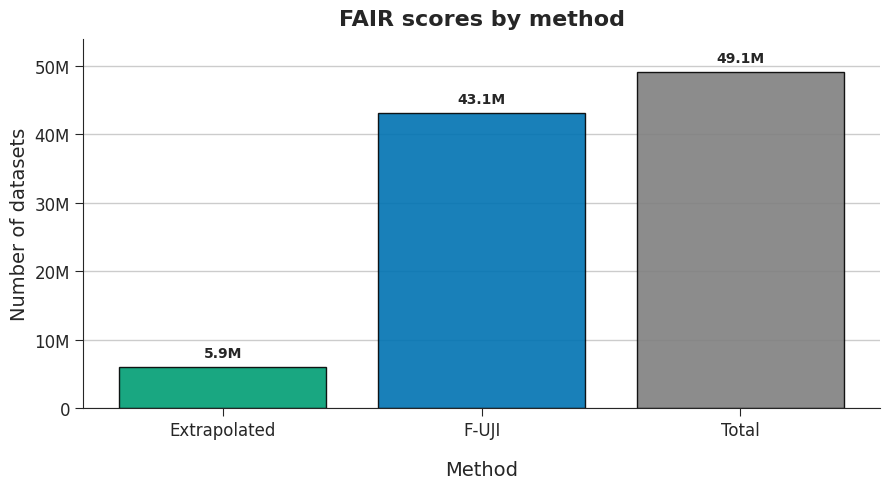

In [18]:
# Setting
color_map = {
    'Extrapolated': color_palette[0], 
    'F-UJI': color_palette[1],       
    'Total': "grey"
}
colors = [color_map.get(method, 'grey') for method in df_fair_scores['method']]

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_fair_scores['method'], 
    df_fair_scores['count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('FAIR scores by method', pad=10)
ax.set_ylabel('Number of datasets')
ax.set_xlabel('Method', labelpad=15)
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

ax.set_ylim(0, df_fair_scores['count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.show()

### Citations

Overview of the citations identified for our datasets

#### Preview table

In [19]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM citations
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,cit_ts,citation_year,citation_weight,source
0,10.1594/ieda/100002,2008-06-01,2008,1.0,"[""mdc""]"
1,10.1594/ieda/100004,2010-01-01,2010,1.0,"[""mdc""]"
2,10.5524/100001,2011-08-25,2011,1.0,"[""datacite"",""mdc""]"


#### Number of citations by citation source and data source

In [20]:
con = duckdb.connect(dataset_db)
query = """
SELECT * FROM (
    SELECT 
        source, 
        COUNT(*) as citation_count
    FROM (
        SELECT unnest(CAST(source AS VARCHAR[])) as source 
        FROM citations
    ) 
    GROUP BY source

    UNION ALL

    SELECT 
        'unique' as source, 
        COUNT(*) as citation_count
    FROM citations
) AS combined_results

ORDER BY (source = 'unique') ASC, citation_count DESC
"""
df_citations_source = con.execute(query).df()
display(df_citations_source.style.format({'citation_count': '{:,}'}))
con.close()

,source,citation_count
0,datacite,"4,641,366"
1,openalex,"2,754,157"
2,mdc,"1,480,491"
3,unique,"7,669,263"


In [21]:
con = duckdb.connect(dataset_db)

query = """
WITH raw_joined AS (
    -- 1. Join tables to get the data_source and the raw citation string
    SELECT 
        m.source AS data_source, 
        c.source AS citation_blob 
    FROM citations c
    JOIN metadata m ON c.dataset_id = m.dataset_id
),
unnested_citations AS (
    -- 2. Cast the string to a list, then unnest
    SELECT 
        data_source, 
        UNNEST(CAST(citation_blob AS VARCHAR[])) AS citation_source
    FROM raw_joined
)
SELECT * FROM (
    -- 3. Count specific citation types (from the unnested data)
    SELECT 
        data_source, 
        citation_source, 
        COUNT(*) AS count
    FROM unnested_citations
    GROUP BY 1, 2

    UNION ALL

    -- 4. Count unique datasets (from the raw joined data)
    SELECT 
        data_source, 
        'unique' AS citation_source, 
        COUNT(*) AS count
    FROM raw_joined
    GROUP BY 1
)
ORDER BY 
    data_source ASC, 
    (citation_source = 'unique') DESC,
    count DESC
"""

df_citations_sources_per_data_source = con.execute(query).df()
display(df_citations_sources_per_data_source)
con.close()

,data_source,citation_source,count
0,datacite,unique,7654129
1,datacite,datacite,4641366
2,datacite,openalex,2754157
3,datacite,mdc,1465357
4,emdb,unique,15134
5,emdb,mdc,15134


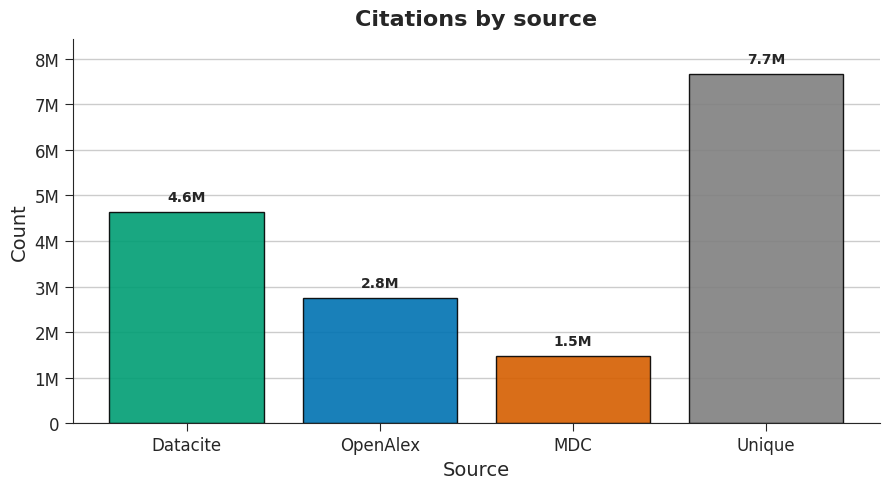

In [22]:
# Plot
label_mapping = {
    'datacite': 'Datacite',
    'openalex': 'OpenAlex',
    'mdc': 'MDC',
    'unique': 'Unique'
}
df_citations_source['source'] = df_citations_source['source'].replace(label_mapping)

color_map = {
    'Datacite': color_palette[0],
    'OpenAlex': color_palette[1],
    'MDC': color_palette[2],
    'Unique': "grey"
}
colors = [color_map[source] for source in df_citations_source['source']]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_citations_source['source'], 
    df_citations_source['citation_count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Citations by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar 
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02), 
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_citations_source['citation_count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.show()

### Mentions

Overview of the mentions identified for our datasets

#### Preview table

In [23]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM mentions
WHERE mention_weight>1.0
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,men_ts,mention_year,mention_weight,source
0,10.57967/hf/0737,2024-03-11,2024,1.23,"[""hf""]"
1,10.57967/hf/0737,2024-05-18,2024,1.23,"[""hf""]"
2,10.57967/hf/0737,2024-07-12,2024,1.23,"[""hf""]"


#### Number of mentions by source

In [24]:
con = duckdb.connect(dataset_db)
query = """
SELECT * FROM (
    SELECT 
        source, 
        COUNT(*) as mention_count
    FROM (
        SELECT unnest(CAST(source AS VARCHAR[])) as source 
        FROM mentions
    ) 
    GROUP BY source

    UNION ALL

    SELECT 
        'unique' as source, 
        COUNT(*) as mention_count
    FROM mentions
) AS combined_results

ORDER BY (source = 'unique') ASC, mention_count DESC
"""
df_mentions_source = con.execute(query).df()
display(df_mentions_source.style.format({'mention_count': '{:,}'}))
con.close()

,source,mention_count
0,swh,"85,129"
1,hf,"5,243"
2,uspto,"1,519"
3,unique,"91,891"


In [25]:
con = duckdb.connect(dataset_db)

query = """
WITH raw_joined AS (
    -- 1. Join mentions and metadata to get the data_source
    SELECT 
        md.source AS data_source, 
        m.source AS mention_blob 
    FROM mentions m
    JOIN metadata md ON m.dataset_id = md.dataset_id
),
unnested_mentions AS (
    -- 2. Cast the blob to a list and unnest it
    SELECT 
        data_source, 
        UNNEST(CAST(mention_blob AS VARCHAR[])) AS mention_source
    FROM raw_joined
)
SELECT * FROM (
    -- 3. Count specific mention types (from the unnested data)
    SELECT 
        data_source, 
        mention_source, 
        COUNT(*) AS mention_count
    FROM unnested_mentions
    GROUP BY 1, 2

    UNION ALL

    -- 4. Count unique datasets (from the raw joined data)
    SELECT 
        data_source, 
        'unique' AS mention_source, 
        COUNT(*) AS mention_count
    FROM raw_joined
    GROUP BY 1
)
ORDER BY 
    data_source ASC, 
    -- Puts 'unique' at the top of each data_source group
    (mention_source = 'unique') DESC,
    mention_count DESC
"""

df_mentions_source_per_data_source = con.execute(query).df()

# Display with formatting
display(df_mentions_source_per_data_source.style.format({'mention_count': '{:,}'}))

con.close()

,data_source,mention_source,mention_count
0,datacite,unique,"90,428"
1,datacite,swh,"85,014"
2,datacite,hf,"5,243"
3,datacite,uspto,171
4,emdb,unique,"1,463"
5,emdb,uspto,"1,348"
6,emdb,swh,115


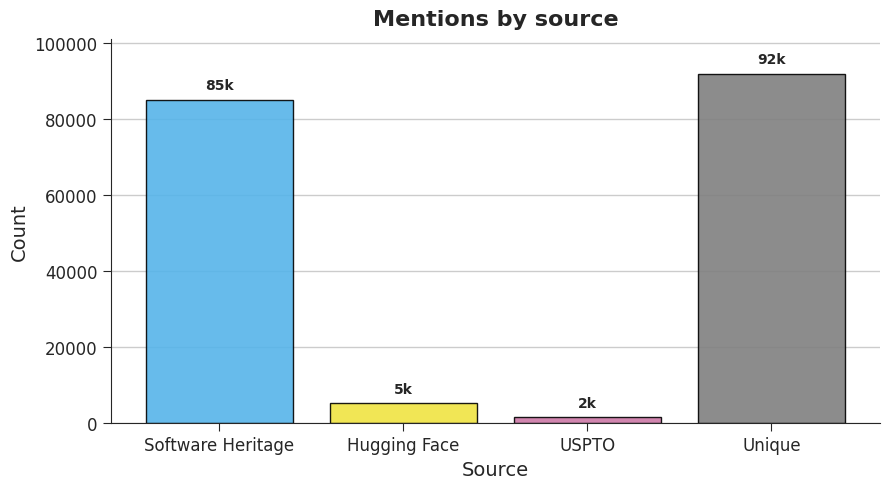

In [28]:
# Plot
label_mapping = {
    'swh': 'Software Heritage',
    'hf': 'Hugging Face',
    "uspto": "USPTO",
    'unique': 'Unique'
}
df_mentions_source['source'] = df_mentions_source['source'].replace(label_mapping)

color_map = {
    'Software Heritage': color_palette[3],
    'Hugging Face': color_palette[4],
    'USPTO': color_palette[5],
    'Unique': "grey"
}
colors = [color_map[source] for source in df_mentions_source['source']]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_mentions_source['source'], 
    df_mentions_source['mention_count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Mentions by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_mentions_source['mention_count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.savefig('output/mentions_source.png', dpi=300)
plt.show()

## Research fields

Overview of the research fields assigned using the OpenAlex taxonomy

### Preview table

In [29]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM topics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,topic_id,topic_name,score,source,subfield_id,subfield_name,field_id,field_name,domain_id,domain_name
0,10.5287/bodleian6zr1.2,T12375,Cuban History and Society,0.2431,custom_model,3312,Sociology and Political Science,33,Social Sciences,2,Social Sciences
1,10.5287/bodleian8irf.2,T11803,Superconducting and THz Device Technology,0.2526,custom_model,3103,Astronomy and Astrophysics,31,Physics and Astronomy,3,Physical Sciences
2,10.5287/bodleian2pyz.2,T12860,Family and Patient Care in Intensive Care Units,0.2824,custom_model,3614,Radiological and Ultrasound Technology,36,Health Professions,4,Health Sciences


In [30]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM topics
WHERE (topic_id IS NULL AND source='openalex')
LIMIT 3
"""
df = con.execute(query).df()
display(df)

,dataset_id,topic_id,topic_name,score,source,subfield_id,subfield_name,field_id,field_name,domain_id,domain_name


### Topics source

In [31]:
con = duckdb.connect(dataset_db)

query = """
WITH combined_models AS (
    -- 1. Get OpenAlex Data linked to Source
    SELECT 
        'OpenAlex' AS model,
        m.source AS data_source,
        t.topic_id
    FROM topics_oa t
    JOIN metadata m ON t.dataset_id = m.dataset_id

    UNION ALL

    -- 2. Get Custom Model Data linked to Source
    SELECT 
        'Custom Model' AS model,
        m.source AS data_source,
        t.topic_id
    FROM topics_custom_model t
    JOIN metadata m ON t.dataset_id = m.dataset_id
)
SELECT 
    model,
    COALESCE(data_source, 'All Sources') AS data_source,
    
    -- Count rows where topic_id is NOT NULL
    COUNT(topic_id) AS assigned_count,
    
    -- Count rows where topic_id IS NULL
    COUNT(*) FILTER (WHERE topic_id IS NULL) AS unassigned_count,
    
FROM combined_models
GROUP BY GROUPING SETS (
    (model, data_source), -- Breakdown by Source
    (model)               -- Total per Model
)
ORDER BY 
    model, 
    data_source
"""

df_topics_breakdown = con.execute(query).df()
display(df_topics_breakdown.style.format({
    'assigned_count': '{:,}', 
    'unassigned_count': '{:,}'
}))

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,model,data_source,assigned_count,unassigned_count
0,Custom Model,All Sources,"49,035,606","25,561"
1,Custom Model,datacite,"48,983,961","25,561"
2,Custom Model,emdb,"51,645",0
3,OpenAlex,All Sources,"15,324,819",0
4,OpenAlex,datacite,"15,324,819",0


In [32]:
# Total after merge logic (OpenAlex if score>0.5 else better of the two)
con = duckdb.connect(dataset_db)
query = """
    SELECT 
        CASE 
            WHEN GROUPING(display_source) = 1 THEN 'Total'
            ELSE display_source 
        END as source,
        COUNT(*) as count
    FROM (
        SELECT 
            CASE 
                WHEN topic_id IS NULL THEN 'not_assigned' 
                ELSE source 
            END as display_source
        FROM topics
    )
    GROUP BY ROLLUP(display_source)
    ORDER BY GROUPING(display_source) ASC, count DESC
"""
df_topics_source = con.sql(query).df()
display(df_topics_source.style.format({'count': '{:,}'}))
con.close()

,source,count
0,custom_model,"41,650,357"
1,openalex,"7,394,117"
2,not_assigned,"16,693"
3,Total,"49,061,167"


In [33]:
con = duckdb.connect(dataset_db)

query = """
WITH joined_data AS (
    SELECT 
        m.source AS data_source,
        -- Logic to categorize the assignment source
        CASE 
            WHEN t.topic_id IS NULL THEN 'Not Assigned' 
            ELSE t.source 
        END AS assignment_source
    FROM topics t
    JOIN metadata m ON t.dataset_id = m.dataset_id
)
SELECT 
    COALESCE(data_source, 'All Data Sources') AS data_source,
    COALESCE(assignment_source, 'Total') AS assignment_source,
    COUNT(*) AS count,
FROM joined_data
GROUP BY ROLLUP(data_source, assignment_source)
ORDER BY 
    -- Sorts by Data Source, keeping Totals at the bottom of each group
    GROUPING(data_source),
    data_source, 
    GROUPING(assignment_source),
    count DESC
"""

df_topics_breakdown = con.execute(query).df()

display(df_topics_breakdown)

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,data_source,assignment_source,count
0,datacite,custom_model,41598712
1,datacite,openalex,7394117
2,datacite,Not Assigned,16693
3,datacite,Total,49009522
4,emdb,custom_model,51645
5,emdb,Total,51645
6,All Data Sources,Total,49061167


,source,count
0,Custom model,41650357
1,OpenAlex,7394117
2,None,16693
3,Total,49061167


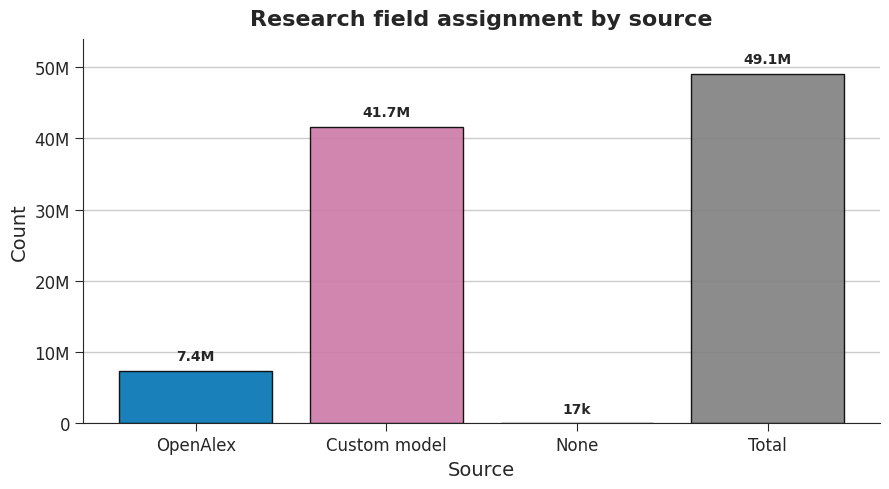

In [34]:
# Plot
label_mapping = {
    'openalex': 'OpenAlex',
    'custom_model': 'Custom model',
    'not_assigned': 'None'
}
df_topics_source['source'] = df_topics_source['source'].replace(label_mapping)
display(df_topics_source)
desired_order = ['OpenAlex', 'Custom model', 'None', 'Total']
df_topics_source['source'] = pd.Categorical(df_topics_source['source'], categories=desired_order, ordered=True)
df_topics_source = df_topics_source.sort_values('source')

color_map = {
    'OpenAlex': color_palette[1],
    'Custom model': color_palette[5],
    'None': 'lightgrey',
    'Total': 'grey'
}
colors = [color_map[source] for source in df_topics_source['source']]


fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_topics_source['source'], 
    df_topics_source['count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Research field assignment by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_topics_source['count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.show()

### Combined plot

C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\341036547.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(new_labels)
C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\341036547.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(new_labels)


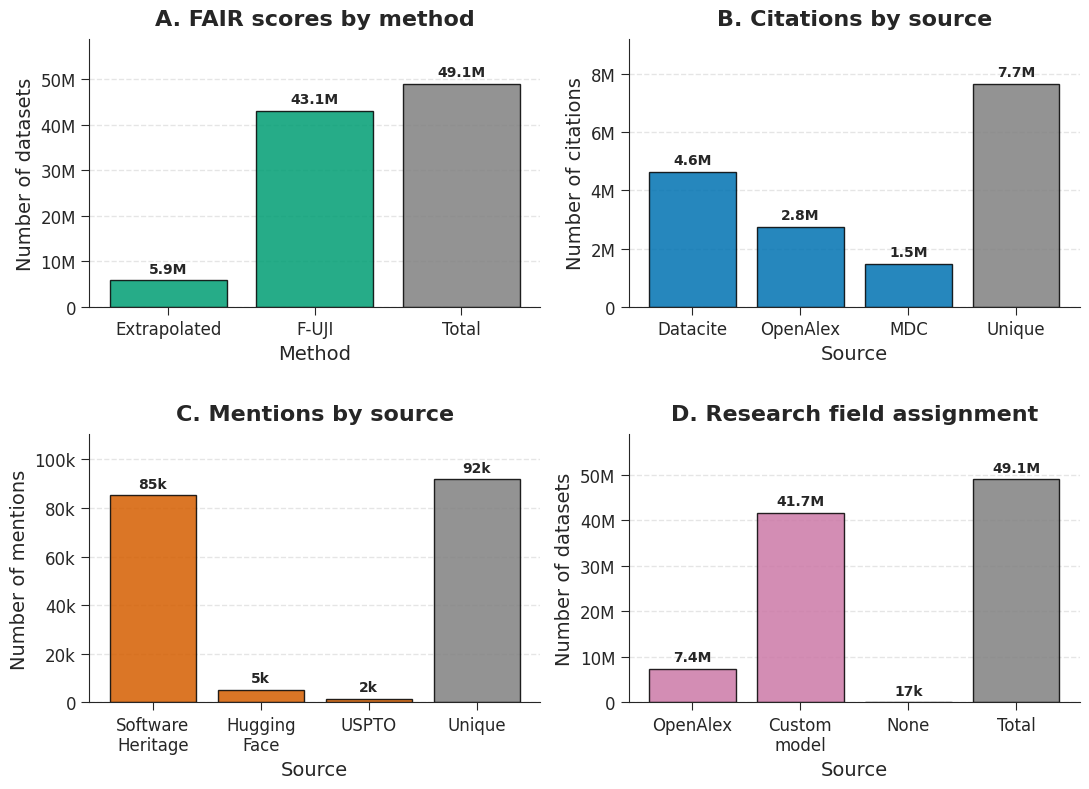

In [69]:
def style_subplot(ax, title, xlabel, ylabel="Count"):
    ax.set_title(title, fontweight='bold', pad=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_k_m(x)))
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    sns.despine(ax=ax)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

## TOP LEFT: FAIR score by method
ax1 = axes[0, 0]
colors1 = [color_palette[0], color_palette[0], "grey"]

bars1 = ax1.bar(
    df_fair_scores['method'], 
    df_fair_scores['count'], 
    color=colors1, 
    edgecolor='black', 
    alpha=0.85
)

style_subplot(ax1, "A. FAIR scores by method", "Method", "Number of datasets")
ax1.set_ylim(0, df_fair_scores['count'].max() * 1.15) # Add headroom for labels

# 2. TOP RIGHT: Citations by source
ax2 = axes[0, 1]
map2 = {'datacite': 'Datacite', 'openalex': 'OpenAlex', 'mdc': 'MDC', 'unique': 'Unique'}
df_citations_source['source'] = df_citations_source['source'].replace(map2)
colors2 = [color_palette[1], color_palette[1], color_palette[1], "grey"]

bars2 = ax2.bar(df_citations_source['source'], df_citations_source['citation_count'], color=colors2, edgecolor='black', alpha=0.85)
style_subplot(ax2, "B. Citations by source", "Source", "Number of citations")

# 3. BOTTOM LEFT: Mentions by source
ax3 = axes[1, 0]
map3 = {'swh': 'Software Heritage', 'huggingface': 'Hugging Face', "uspto": "USPTO", 'unique': 'Unique'}
df_mentions_source['source'] = df_mentions_source['source'].replace(map3)
colors3 = [color_palette[2], color_palette[2], color_palette[2], "grey"]

bars3 = ax3.bar(df_mentions_source['source'], df_mentions_source['mention_count'], color=colors3, edgecolor='black', alpha=0.85)
style_subplot(ax3, "C. Mentions by source", "Source", "Number of mentions")
current_labels = [item.get_text() for item in ax3.get_xticklabels()]
new_labels = [label.replace(' ', '\n', 1) for label in current_labels]
ax3.set_xticklabels(new_labels)

# 4. BOTTOM RIGHT: Research field 
ax4 = axes[1, 1]
map4 = {'openalex': 'OpenAlex', 'custom_model': 'Custom model', 'not_assigned': 'None'}
df_topics_source['source'] = df_topics_source['source'].replace(map4)
desired_order = ['OpenAlex', 'Custom model', 'None', 'Total']
df_topics_source['source'] = pd.Categorical(df_topics_source['source'], categories=desired_order, ordered=True)
df_topics_source = df_topics_source.sort_values('source')
colors4 = [color_palette[5], color_palette[5], "lightgrey", "grey"]

bars4 = ax4.bar(df_topics_source['source'], df_topics_source['count'], color=colors4, edgecolor='black', alpha=0.85)
style_subplot(ax4, "D. Research field assignment", "Source", "Number of datasets")
current_labels = [item.get_text() for item in ax4.get_xticklabels()]
new_labels = [label.replace(' ', '\n', 1) for label in current_labels]
ax4.set_xticklabels(new_labels)

# Axis settings to fit labels
all_bars = [bars1, bars2, bars3, bars4]
all_axes = [ax1, ax2, ax3, ax4]

for ax, bars in zip(all_axes, all_bars):
    max_h = max([b.get_height() for b in bars]) if len(bars) > 0 else 1
    ax.set_ylim(0, max_h * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (max_h * 0.02),
                format_k_m(height), ha='center', va='bottom', fontweight='bold', fontsize=10)

sns.despine()

plt.tight_layout(h_pad=3.0)
plt.savefig('output/combined_data_for_Sindex.png', dpi=300)
plt.show()

### Distributions of FAIR scores, Citations, Mentions across datasets

#### Preview table

In [36]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM dataset_metrics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pubyear,creators,dataset_source,topic_id,topic_name,topic_score,subfield_id,subfield_name,field_id,...,total_citations,total_cit_weight,cit_3yr,cit_weight_3yr,total_mentions,total_men_weight,men_3yr,men_weight_3yr,raw_dataset_index,raw_dataset_index_3yr
0,10.57451/lhd.ech.102357.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.5071,3109,Statistical and Nonlinear Physics,31,...,0,0.0,0,0.0,0,0.0,0,0.0,0.044867,0.044867
1,10.57451/lhd.ech.102358.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.5012,3109,Statistical and Nonlinear Physics,31,...,0,0.0,0,0.0,0,0.0,0,0.0,0.044867,0.044867
2,10.57451/lhd.ech.102359.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.5028,3109,Statistical and Nonlinear Physics,31,...,0,0.0,0,0.0,0,0.0,0,0.0,0.044867,0.044867


#### Distributions table

In [37]:
con = duckdb.connect(dataset_db)

query = """
SELECT 
    -- FAIR Score
    AVG(fair_score) as "FAIR_Avg",
    MEDIAN(fair_score) as "FAIR_Median",
    MIN(fair_score) as "FAIR_Min",
    MAX(fair_score) as "FAIR_Max",
    COUNT(DISTINCT fair_score) as "FAIR_UniqueCount", 
    AVG(CASE WHEN fair_score > 0 THEN fair_score END) as "FAIR_AvgNonZero",

    QUANTILE_CONT(fair_score, 0.90) as "FAIR_90th",
    QUANTILE_CONT(fair_score, 0.95) as "FAIR_95th",
    QUANTILE_CONT(fair_score, 0.99) as "FAIR_99th",
    STDDEV(fair_score) as "FAIR_StdDev",
    SKEWNESS(fair_score) as "FAIR_Skew",
    (COUNT(CASE WHEN fair_score = 0 THEN 1 END) * 100.0 / COUNT(*)) as "FAIR_ZeroPct",


    -- Citations
    AVG(total_citations) as "Citations_Avg",
    MEDIAN(total_citations) as "Citations_Median",
    MIN(total_citations) as "Citations_Min",
    MAX(total_citations) as "Citations_Max",
    SUM(total_citations) as "Citations_Sum", 
    AVG(CASE WHEN total_citations > 0 THEN total_citations END) as "Citations_AvgNonZero",

    QUANTILE_CONT(total_citations, 0.90) as "Citations_90th",
    QUANTILE_CONT(total_citations, 0.95) as "Citations_95th",
    QUANTILE_CONT(total_citations, 0.99) as "Citations_99th",
    STDDEV(total_citations) as "Citations_StdDev",
    SKEWNESS(total_citations) as "Citations_Skew",
    (COUNT(CASE WHEN total_citations = 0 THEN 1 END) * 100.0 / COUNT(*)) as "Citations_ZeroPct",


    -- Mentions
    AVG(total_mentions) as "Mentions_Avg",
    MEDIAN(total_mentions) as "Mentions_Median",
    MIN(total_mentions) as "Mentions_Min",
    MAX(total_mentions) as "Mentions_Max",
    SUM(total_mentions) as "Mentions_Sum",
    AVG(CASE WHEN total_mentions > 0 THEN total_mentions END) as "Mentions_AvgNonZero",

    QUANTILE_CONT(total_mentions, 0.90) as "Mentions_90th",
    QUANTILE_CONT(total_mentions, 0.95) as "Mentions_95th",
    QUANTILE_CONT(total_mentions, 0.99) as "Mentions_99th",
    STDDEV(total_mentions) as "Mentions_StdDev",
    SKEWNESS(total_mentions) as "Mentions_Skew",
    (COUNT(CASE WHEN total_mentions = 0 THEN 1 END) * 100.0 / COUNT(*)) as "Mentions_ZeroPct"

FROM dataset_metrics
"""

df_raw = con.execute(query).df()

df_melted = df_raw.melt(var_name="temp_col", value_name="value")
df_melted[['Metric', 'Stat']] = df_melted['temp_col'].str.split('_', expand=True)
final_table = df_melted.pivot(index='Stat', columns='Metric', values='value')
final_table = final_table[['FAIR', 'Citations', 'Mentions']]

row_order = [
    'Sum', 'UniqueCount',            
    'Avg', 'AvgNonZero',             
    'Median', 'Min', 'Max', 
    '90th', '95th', '99th', 
    'StdDev', 'Skew', 
    'ZeroPct'
]
final_table = final_table.reindex(row_order)
final_table = final_table.reset_index()

pd.options.display.float_format = '{:,.2f}'.format
display(final_table)

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Metric,Stat,FAIR,Citations,Mentions
0,Sum,NaN,"7,669,263.00","91,891.00"
1,UniqueCount,37.00,NaN,NaN
2,Avg,19.57,0.16,0.00
3,AvgNonZero,19.57,3.71,4.77
4,Median,13.46,0.00,0.00
5,Min,13.46,0.00,0.00
6,Max,100.00,"30,948.00","1,485.00"
7,90th,30.77,0.00,0.00
8,95th,55.77,0.00,0.00
9,99th,84.62,1.00,0.00


#### Plots

In [38]:
# Data
con = duckdb.connect(dataset_db)
query_fair = """
SELECT 
    fair_score as Score, 
    COUNT(*) as Count 
FROM dataset_metrics 
GROUP BY fair_score 
ORDER BY Score ASC
"""
df_fair_counts = con.execute(query_fair).df()

# Calculate the exact number of zero vs non-zero
query_counts = """
SELECT 
    COUNT(CASE WHEN total_citations = 0 THEN 1 END) as n_zero_c,
    COUNT(CASE WHEN total_citations > 0 THEN 1 END) as n_pos_c,
    COUNT(CASE WHEN total_mentions = 0 THEN 1 END) as n_zero_m,
    COUNT(CASE WHEN total_mentions > 0 THEN 1 END) as n_pos_m
FROM dataset_metrics
"""
counts_df = con.execute(query_counts).df()

# Extract single integers for the Pie Charts
n_zero_c = counts_df['n_zero_c'][0]
n_pos_c  = counts_df['n_pos_c'][0]
n_zero_m = counts_df['n_zero_m'][0]
n_pos_m  = counts_df['n_pos_m'][0]

# Get non-zero values for histograms
query_c_hist = "SELECT total_citations FROM dataset_metrics WHERE total_citations > 0"
non_zero_cites = con.execute(query_c_hist).df()['total_citations']

query_m_hist = "SELECT total_mentions FROM dataset_metrics WHERE total_mentions > 0"
non_zero_mentions = con.execute(query_m_hist).df()['total_mentions']
con.close()

C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\3172258623.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


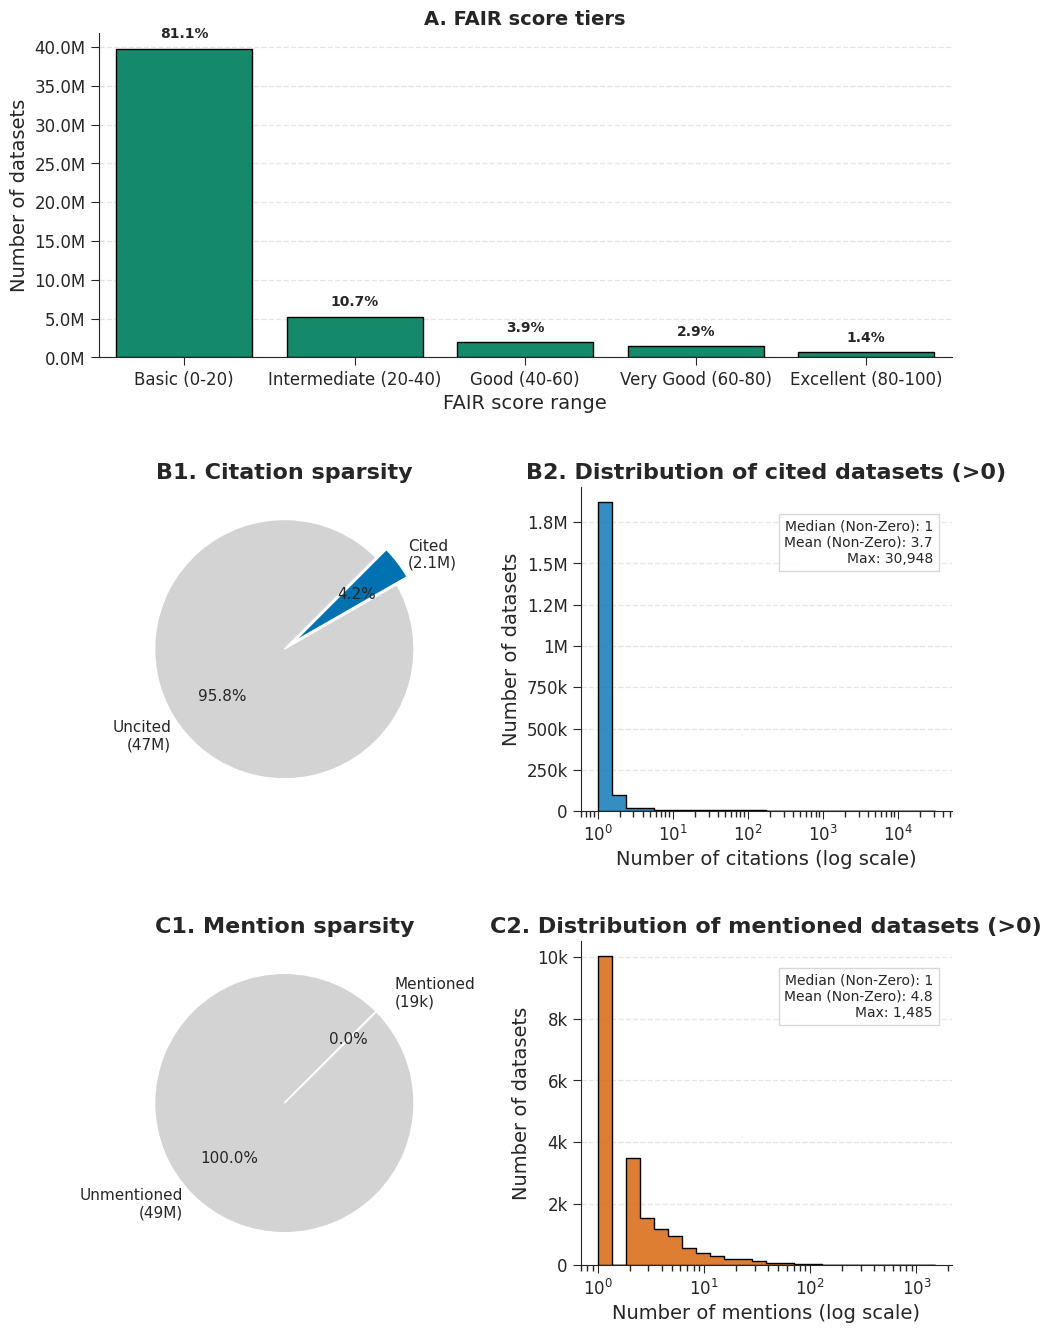

In [39]:
# Pre-processing
bins = [0, 20, 40, 60, 80, 100]
labels = ['Basic (0-20)', 'Intermediate (20-40)', 'Good (40-60)', 'Very Good (60-80)', 'Excellent (80-100)']
df_fair_grouped = df_fair_counts.copy()
df_fair_grouped['Group'] = pd.cut(df_fair_grouped['Score'], bins=bins, labels=labels, right=True)
df_plot_fair = df_fair_grouped.groupby('Group', observed=False)['Count'].sum().reset_index()

# Plot
fig = plt.figure(figsize=(11, 16))
gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)

# ROW 1: FAIR scores
ax_fair = fig.add_subplot(gs[0, :])

base_rgb = to_rgba(color_palette[0])
fair_colors = [
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.4),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.55),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.7),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.85),
    (base_rgb[0], base_rgb[1], base_rgb[2], 1.0)
]

bars = sns.barplot(
    data=df_plot_fair, 
    x='Group', 
    y='Count', 
    palette=fair_colors, 
    hue='Group', 
    legend=False, 
    edgecolor='black',
    width=0.8,
    dodge=False 
)

ax_fair.set_title('A. FAIR score tiers', fontweight='bold', fontsize=14)
ax_fair.set_xlabel('FAIR score range')
ax_fair.set_ylabel('Number of datasets')
ax_fair.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax_fair.grid(axis='y', linestyle='--', alpha=0.5)

total_datasets = df_plot_fair['Count'].sum()
for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        percentage = (height / total_datasets) * 100
        ax_fair.text(
            bar.get_x() + bar.get_width()/2., 
            height + (total_datasets * 0.02), 
            f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold'
        )
sns.despine(ax=ax_fair)


# ROW 2: Citations

# Left: Pie Chart
ax_cite_pie = fig.add_subplot(gs[1, 0])
ax_cite_pie.pie(
    [n_zero_c, n_pos_c], 
    labels=[f'Uncited\n({format_k_m(n_zero_c)})', f'Cited\n({format_k_m(n_pos_c)})'], 
    autopct='%1.1f%%', 
    colors=['lightgrey', color_palette[1]], 
    explode=(0, 0.1), 
    startangle=45,
    textprops={'fontsize': 11}
)
ax_cite_pie.set_title('B1. Citation sparsity', fontweight='bold')

# Right: Log Histogram 
ax_cite_hist = fig.add_subplot(gs[1, 1])

max_val_c = non_zero_cites.max()
log_bins_c = np.logspace(0, np.log10(max_val_c), 25)

sns.histplot(
    non_zero_cites, 
    bins=log_bins_c, 
    ax=ax_cite_hist, 
    color=color_palette[1], 
    edgecolor='black', 
    alpha=0.8,
    element="step", 
    fill=True
)
ax_cite_hist.set_xscale('log')
ax_cite_hist.set_title('B2. Distribution of cited datasets (>0)', fontweight='bold')
ax_cite_hist.set_xlabel('Number of citations (log scale)')
ax_cite_hist.set_ylabel('Number of datasets')
ax_cite_hist.grid(axis='y', linestyle='--', alpha=0.5)
ax_cite_hist.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_k_m(x)))

median_c = non_zero_cites.median()
mean_c = non_zero_cites.mean()
stats_text_c = (
    f"Median (Non-Zero): {int(median_c)}\n" 
    f"Mean (Non-Zero): {mean_c:.1f}\n"      
    f"Max: {int(non_zero_cites.max()):,}"
)
ax_cite_hist.text(0.95, 0.90, stats_text_c, transform=ax_cite_hist.transAxes, 
                  ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgrey'))
sns.despine(ax=ax_cite_hist)


# ROW 3: Mentions

# Left: Pie Chart
ax_ment_pie = fig.add_subplot(gs[2, 0])
ax_ment_pie.pie(
    [n_zero_m, n_pos_m], 
    labels=[f'Unmentioned\n({format_k_m(n_zero_m)})', f'Mentioned\n({format_k_m(n_pos_m)})'], 
    autopct='%1.1f%%', 
    colors=['lightgrey', color_palette[2]], 
    explode=(0, 0.1), 
    startangle=45,
    textprops={'fontsize': 11}
)
ax_ment_pie.set_title('C1. Mention sparsity', fontweight='bold')

# Right: Log Histogram 
ax_ment_hist = fig.add_subplot(gs[2, 1])

max_val_m = non_zero_mentions.max()
log_bins_m = np.logspace(0, np.log10(max_val_m), 25)

sns.histplot(
    non_zero_mentions, 
    bins=log_bins_m, 
    ax=ax_ment_hist, 
    color=color_palette[2], 
    edgecolor='black', 
    alpha=0.8,
    element="step", 
    fill=True
)
ax_ment_hist.set_xscale('log') 
ax_ment_hist.set_title('C2. Distribution of mentioned datasets (>0)', fontweight='bold')
ax_ment_hist.set_xlabel('Number of mentions (log scale)')
ax_ment_hist.set_ylabel('Number of datasets')
ax_ment_hist.grid(axis='y', linestyle='--', alpha=0.5)
ax_ment_hist.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_k_m(x)))

median_m = non_zero_mentions.median()
mean_m = non_zero_mentions.mean()

stats_text_m = (
    f"Median (Non-Zero): {int(median_m)}\n"  
    f"Mean (Non-Zero): {mean_m:.1f}\n"      
    f"Max: {int(non_zero_mentions.max()):,}"
)

ax_ment_hist.text(0.95, 0.90, stats_text_m, transform=ax_ment_hist.transAxes, 
                  ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgrey'))
sns.despine(ax=ax_ment_hist)

# Save
plt.tight_layout()
plt.savefig('output/fair_citations_mentions_distributions.png', dpi=300)
plt.show()

## Distribution of topics and subfields

### Preview table

In [40]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM dataset_metrics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pubyear,creators,dataset_source,topic_id,topic_name,topic_score,subfield_id,subfield_name,field_id,...,total_citations,total_cit_weight,cit_3yr,cit_weight_3yr,total_mentions,total_men_weight,men_3yr,men_weight_3yr,raw_dataset_index,raw_dataset_index_3yr
0,10.57451/lhd.ech.102357.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.51,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
1,10.57451/lhd.ech.102358.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.50,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
2,10.57451/lhd.ech.102359.1,2025,"[{""name"":""MIZUNO, Yoshinori"",""name_type"":""Pers...",datacite,T13769,Fusion and Plasma Physics Studies,0.50,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04


### Number of topics and subfields covered

In [41]:
con = duckdb.connect(dataset_db)
query = "SELECT COUNT(DISTINCT topic_id) FROM dataset_metrics"
unique_topics = con.execute(query).fetchone()[0]
print(f"Unique topics covered in our datasets: {unique_topics}")

query = "SELECT COUNT(DISTINCT subfield_id) FROM dataset_metrics"
unique_subfields = con.execute(query).fetchone()[0]
print(f"Unique topics covered in our datasets: {unique_subfields}")

con.close()

Unique topics covered in our datasets: 4516
Unique topics covered in our datasets: 252


### Frequency of datasets (how many topics/subfileds have 100 dataset, 100 datasets, etc.)

In [42]:
con = duckdb.connect(dataset_db)

topic_df = con.execute("""
    SELECT 
        topic_id,
        ANY_VALUE(topic_name) as topic_name,
        COUNT(dataset_id) as dataset_count
    FROM dataset_metrics
    WHERE topic_id IS NOT NULL  -- Added filter
    GROUP BY topic_id
    ORDER BY dataset_count DESC
""").df()

subfield_df = con.execute("""
    SELECT 
        subfield_id,
        ANY_VALUE(subfield_name) as subfield_name,
        COUNT(dataset_id) as dataset_count
    FROM dataset_metrics
    WHERE subfield_id IS NOT NULL -- Added filter
    GROUP BY subfield_id
    ORDER BY dataset_count DESC
""").df()

print("Top 5 Sufields by Dataset Count:")
print(topic_df.head())

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Top 5 Sufields by Dataset Count:
  topic_id                               topic_name  dataset_count
0   T13769        Fusion and Plasma Physics Studies       13091682
1   T10597  Nuclear reactor physics and engineering        3194892
2   T10015        Genomics and Phylogenetic Studies        2214406
3   T11854    Laser-induced spectroscopy and plasma        1732322
4   T12157        Geochemistry and Geologic Mapping        1586053


In [43]:
# Topics Frequency
df_topic_dataset_freq = topic_df['dataset_count'].value_counts().reset_index()
df_topic_dataset_freq.columns = ['dataset_count', 'num_topics']
df_topic_dataset_freq = df_topic_dataset_freq.sort_values('dataset_count')

# Subfields Frequency
df_subfield_dataset_freq = subfield_df['dataset_count'].value_counts().reset_index()
df_subfield_dataset_freq.columns = ['dataset_count', 'num_subfields']
df_subfield_dataset_freq = df_subfield_dataset_freq.sort_values('dataset_count')

print("Topic Frequency Distribution (First 5 rows):")
print(df_topic_dataset_freq.head())

Topic Frequency Distribution (First 5 rows):
      dataset_count  num_topics
2595              6           1
504               9           3
1002             10           2
2594             11           1
503              12           3


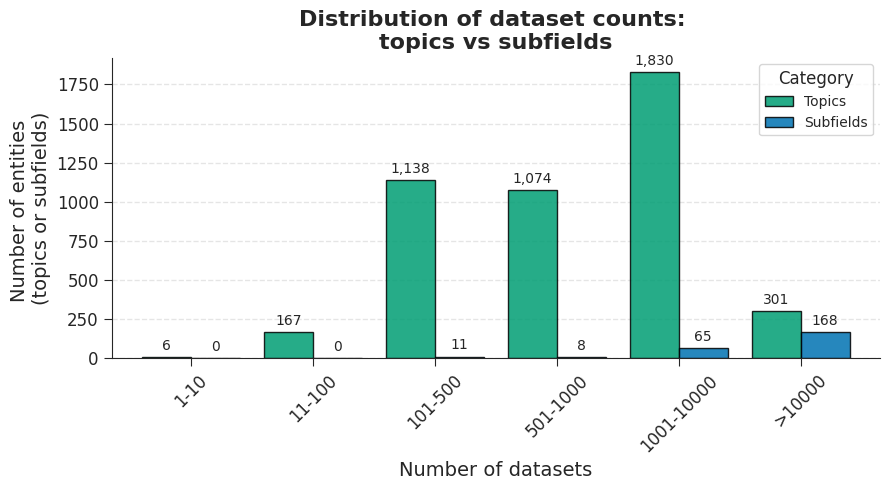

In [44]:
# Bins and labels
bins = [0, 10, 100, 500, 1000, 10000, float('inf')]
labels = ['1-10', '11-100', '101-500', '501-1000', '1001-10000', '>10000']

# Range column for both dfs
topic_df['dataset_range'] = pd.cut(topic_df['dataset_count'], bins=bins, labels=labels)
subfield_df['dataset_range'] = pd.cut(subfield_df['dataset_count'], bins=bins, labels=labels)

# Counts for each range
topic_counts = topic_df['dataset_range'].value_counts().sort_index()
subfield_counts = subfield_df['dataset_range'].value_counts().sort_index()

# Combine into a one df for plotting
df_combined = pd.DataFrame({
    'Topics': topic_counts,
    'Subfields': subfield_counts
})

# Bar chart
ax = df_combined.plot(kind='bar', 
                      figsize=(9, 5), 
                      width=0.8, 
                      color=color_palette, 
                      alpha = 0.85,
                      edgecolor='black')

# Bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Formatting
plt.title('Distribution of dataset counts: \ntopics vs subfields')
plt.xlabel('Number of datasets')
plt.ylabel('Number of entities \n(topics or subfields)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()

# Save
plt.savefig('output/distribution_topics_subfields_dataset_counts.png', dpi=300)
plt.show()

## Evolution of normalization factors over time

### Preview table

In [45]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM normalization_factors_subfields_floored
limit 3
"""

display(con.execute(query).df())
con.close()

,subfield_id,subfield_name,pubyear,median_cit_weight_3yr,cit_is_floored,median_men_weight_3yr,men_is_floored,median_fair_score_3yr,fair_is_floored,n_fair,n_cit,n_men
0,NaN,NaN,<NA>,1.00,True,1.00,True,13.46,False,49061167,49061167,49061167
1,1100,General Agricultural and Biological Sciences,<NA>,1.00,True,1.00,True,13.46,False,43077,43077,43077
2,1102,Agronomy and Crop Science,<NA>,1.00,True,1.00,True,13.46,False,20766,20766,20766


### Stability of the normalization factors

Since there are very little citations and mentions, we focus on the FAIR  only

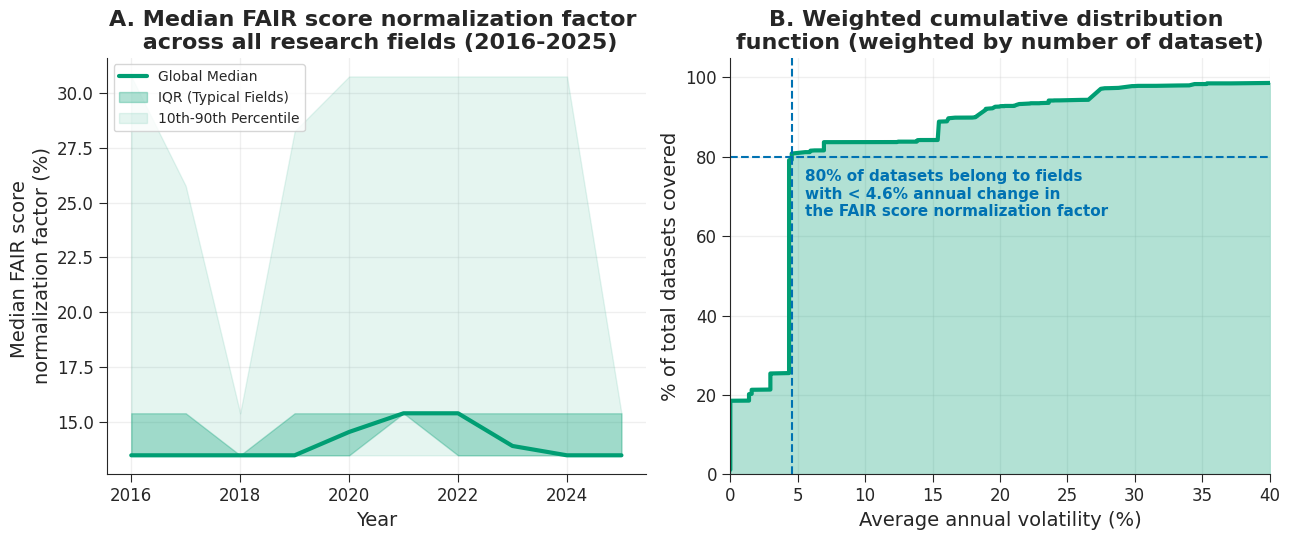

In [77]:
con = duckdb.connect(dataset_db)

# Set the figure size for a single row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.5))

fan_query = """
    SELECT 
        pubyear,
        approx_quantile(median_fair_score_3yr, 0.5) as p50,
        approx_quantile(median_fair_score_3yr, 0.25) as p25,
        approx_quantile(median_fair_score_3yr, 0.75) as p75,
        approx_quantile(median_fair_score_3yr, 0.10) as p10,
        approx_quantile(median_fair_score_3yr, 0.90) as p90
    FROM normalization_factors_subfields_floored
    WHERE pubyear BETWEEN 2016 AND 2025
    GROUP BY pubyear
    ORDER BY pubyear
"""
df_fan = con.execute(fan_query).df()

# Plot Median
ax1.plot(df_fan['pubyear'], df_fan['p50'], color=color_palette[0], linewidth=3, label='Global Median')

# Plot IQR (25-75%) - The "Typical" Range
ax1.fill_between(df_fan['pubyear'], df_fan['p25'], df_fan['p75'], 
                 color=color_palette[0], alpha=0.3, label='IQR (Typical Fields)')

# Plot 10-90% - The "outliers"
ax1.fill_between(df_fan['pubyear'], df_fan['p10'], df_fan['p90'], 
                 color=color_palette[0], alpha=0.1, label='10th-90th Percentile')

ax1.set_title("A. Median FAIR score normalization factor \n across all research fields (2016-2025)")
ax1.set_ylabel("Median FAIR score \nnormalization factor (%)")
ax1.set_xlabel("Year")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

cdf_query = """
    WITH yearly_changes AS (
        SELECT 
            subfield_id,
            n_fair as vol,
            median_fair_score_3yr as val,
            LAG(median_fair_score_3yr) OVER (PARTITION BY subfield_id ORDER BY pubyear) as prev_val
        FROM normalization_factors_subfields_floored
        WHERE pubyear BETWEEN 2016 AND 2025
    ),
    field_stats AS (
        SELECT 
            subfield_id,
            SUM(vol) as total_volume,
            -- Calculate Avg Annual Volatility %
            AVG(ABS(val - prev_val) / NULLIF(prev_val, 0)) * 100 as volatility
        FROM yearly_changes
        WHERE prev_val > 0
        GROUP BY subfield_id
    )
    SELECT volatility, total_volume
    FROM field_stats
    WHERE volatility IS NOT NULL AND volatility < 100
    ORDER BY volatility ASC
"""
df_cdf = con.execute(cdf_query).df()

# Calculate  cumulative stats
df_cdf['cumulative_vol'] = df_cdf['total_volume'].cumsum()
total_vol = df_cdf['total_volume'].sum()
df_cdf['pct_covered'] = (df_cdf['cumulative_vol'] / total_vol) * 100

# Plot CDF
ax2.plot(df_cdf['volatility'], df_cdf['pct_covered'], color=color_palette[0], linewidth=3)
ax2.fill_between(df_cdf['volatility'], df_cdf['pct_covered'], color=color_palette[0], alpha=0.3)

# Add "80% coverage" marker
try:
    # Find the volatility value closest to 80% coverage
    idx = (df_cdf['pct_covered'] - 80).abs().idxmin()
    vol_at_80 = df_cdf.loc[idx, 'volatility']
    
    ax2.axvline(vol_at_80, color=color_palette[1], linestyle='--', alpha=1)
    ax2.axhline(80, color=color_palette[1], linestyle='--', alpha=1)
    
    # Annotation text
    ax2.text(vol_at_80 + 1, 65, 
             f"80% of datasets belong to fields\nwith < {vol_at_80:.1f}% annual change in \nthe FAIR score normalization factor", 
             color=color_palette[1], fontsize=11, fontweight='bold')
except:
    pass

ax2.set_title("B. Weighted cumulative distribution \nfunction (weighted by number of dataset)")
ax2.set_xlabel("Average annual volatility (%)")
ax2.set_ylabel("% of total datasets covered")
ax2.set_ylim(0, 105)
ax2.set_xlim(0, 40) # Focus on the 0-40% range
ax2.grid(True, alpha=0.3)

plt.tight_layout(h_pad=3.0)
plt.savefig('output/fair_score_normalization_factor', dpi=300)
plt.show()

### Preview table

In [47]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM s_index_clean
limit 3
"""
display(con.execute(query).df())
con.close()

,distinct_group_id,grouping_method,display_name,primary_identifier,all_affiliations,name_type,primary_topic_id,primary_topic_name,primary_subfield_id,primary_subfield_name,...,n_datasets,S_index_topics,S_index_subfield,avg_dataset_index_topics,avg_dataset_index_subfield,total_cit_weight,total_men_weight,sum_total_citations,sum_total_mentions,avg_fair_score
0,0000-0001-5473-2109,identifier,"TOKUZAWA, Tokihiko",0000-0001-5473-2109,"[National Institute for Fusion Science (NIFS),...",Personal,T13769,Fusion and Plasma Physics Studies,3109,Statistical and Nonlinear Physics,...,5727142,"1,239,587.70","1,516,425.39",0.22,0.26,0.00,0.00,0.00,0.00,14.67
1,https://nrid.nii.ac.jp/nrid/1000050260047/,identifier,"TANAKA, Kenji",https://nrid.nii.ac.jp/nrid/1000050260047/,"[National Institute for Fusion Science (NIFS),...",Personal,T13769,Fusion and Plasma Physics Studies,3109,Statistical and Nonlinear Physics,...,3208893,"987,917.55","984,453.29",0.31,0.31,0.00,0.00,0.00,0.00,14.79
2,https://nrid.nii.ac.jp/nrid/1000040300727/,identifier,"FUNABA, Hisamichi",https://nrid.nii.ac.jp/nrid/1000040300727/,"[National Institute for Fusion Science (NIFS),...",Personal,T13769,Fusion and Plasma Physics Studies,3109,Statistical and Nonlinear Physics,...,2104401,"806,226.49","789,131.56",0.38,0.37,"242,317.38",0.00,"197,006.00",0.00,15.51


### Count

In [48]:
con = duckdb.connect(dataset_db)

query = """
SELECT 
    CASE 
        WHEN GROUPING(grouping_method) = 1 THEN 'Total'
        ELSE grouping_method 
    END AS grouping_method,
    COUNT(*) AS count,
    -- Calculate percentage based on the total table count
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM s_index_clean), 2) AS percentage
FROM s_index_clean
GROUP BY ROLLUP(grouping_method)
ORDER BY count DESC
"""

df_s_index_counts = con.execute(query).df()
display(df_s_index_counts)
con.close()

,grouping_method,count,percentage
0,Total,1032543,100.00
1,name_affiliation,686019,66.44
2,identifier,346524,33.56


In [49]:
con = duckdb.connect(dataset_db)
query = """
SELECT 
    COUNT(DISTINCT primary_subfield_id)
FROM s_index_clean
"""
display(con.execute(query).df())
con.close()

,count(DISTINCT primary_subfield_id)
0,252


### Distribution

In [50]:
con = duckdb.connect(dataset_db)
df_stats_sindex = con.execute("""
    SELECT
        MIN(S_index_subfield) as min,
        AVG(S_index_subfield) as avg,
        QUANTILE_CONT(S_index_subfield, 0.10) as p10,
        QUANTILE_CONT(S_index_subfield, 0.25) as p25,
        QUANTILE_CONT(S_index_subfield, 0.50) as median_p50,
        QUANTILE_CONT(S_index_subfield, 0.75) as p75,
        QUANTILE_CONT(S_index_subfield, 0.90) as p90,
        QUANTILE_CONT(S_index_subfield, 0.99) as p99,
        QUANTILE_CONT(S_index_subfield, 0.999) as p99_9,
        MAX(S_index_subfield) as max,
        STDDEV(S_index_subfield) as std_dev,
        COUNT(*) as total_authors
    FROM s_index_clean
""").df()
con.close()

In [51]:
display(df_stats_sindex.T)

,0
min,0.05
avg,34.43
p10,0.62
p25,1.27
median_p50,2.24
p75,4.17
p90,9.25
p99,89.85
p99_9,"1,094.23"
max,"1,516,425.39"


### Data

In [52]:
con = duckdb.connect(dataset_db)
df_sindex = con.execute("""
    SELECT S_index_subfield, primary_subfield_name 
    FROM s_index_clean 
""").df()
con.close()

### Histogram

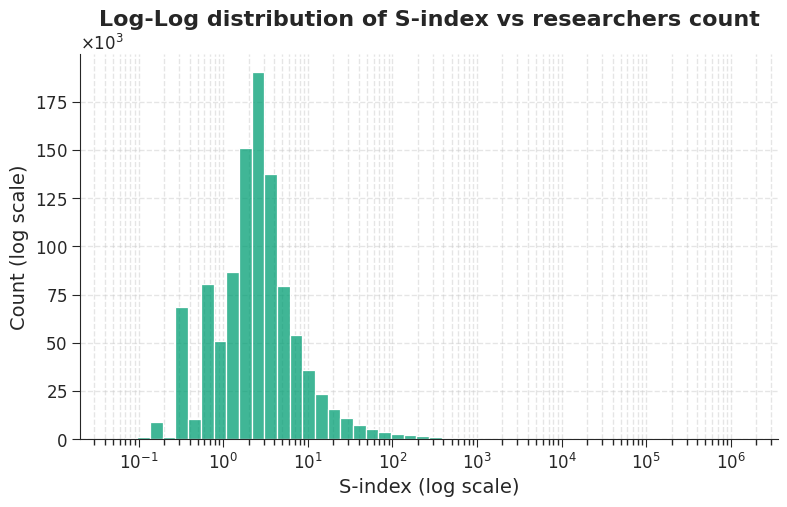

In [53]:
# Plot
plt.figure(figsize=(9, 5))
sns.histplot(
    data=df_sindex, 
    x='S_index_subfield',
    color=color_palette[0],
    log_scale=True,
    bins=50
)
ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useMathText=True)

plt.title('Log-Log distribution of S-index vs researchers count')
plt.xlabel('S-index (log scale)')
plt.ylabel('Count (log scale)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Reverse Cumulative Distribution Function (1 - ECDF) plot

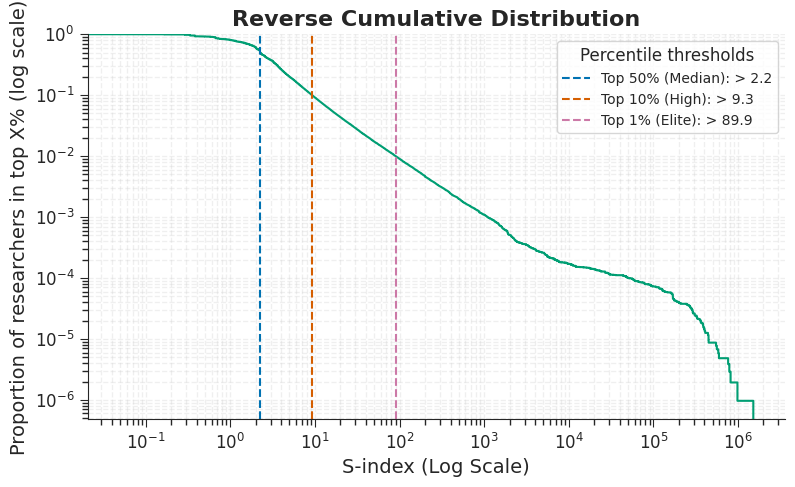

In [54]:
# Percentile values
p50 = df_sindex['S_index_subfield'].quantile(0.50) # Median
p90 = df_sindex['S_index_subfield'].quantile(0.90) # Top 10%
p99 = df_sindex['S_index_subfield'].quantile(0.99) # Top 1%

plt.figure(figsize=(9, 5))

# Reverse CDF (1 - ECDF)
sns.ecdfplot(data=df_sindex, x='S_index_subfield', color=color_palette[0], complementary=True)

# Set Log Scale
plt.yscale('log') 
plt.xscale('log') 

# Add reference lines
plt.axvline(p50, color=color_palette[1], linestyle='--', label=f'Top 50% (Median): > {p50:.1f}')
plt.axvline(p90, color=color_palette[2], linestyle='--', label=f'Top 10% (High): > {p90:.1f}')
plt.axvline(p99, color=color_palette[5], linestyle='--', label=f'Top 1% (Elite): > {p99:.1f}')

# Formatting
plt.title('Reverse Cumulative Distribution')
plt.xlabel('S-index (Log Scale)')
plt.ylabel('Proportion of researchers in top X% (log scale)')
plt.legend(title='Percentile thresholds')
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.show()

C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\1424122589.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped,rotation=45, ha="right", fontsize = 9)  # ha can be "right"/"left" too


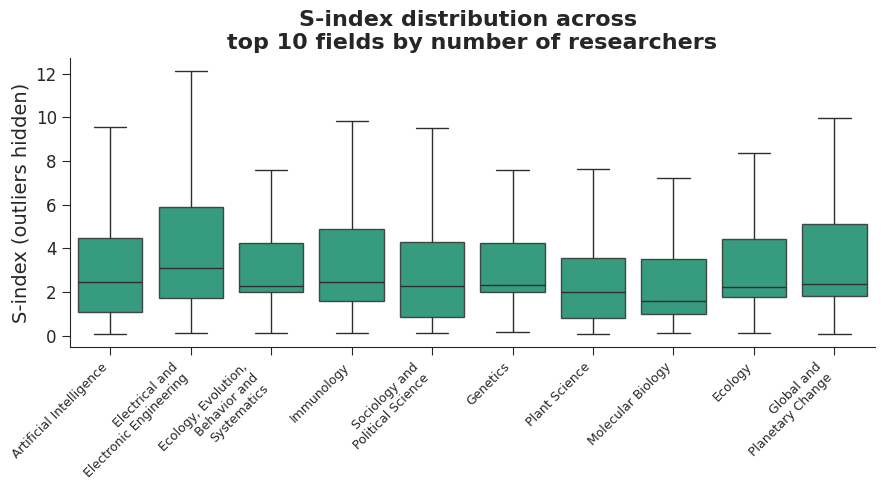

In [55]:
top_subfields = df_sindex['primary_subfield_name'].value_counts().head(10).index
df_subset = df_sindex[df_sindex['primary_subfield_name'].isin(top_subfields)]

plt.figure(figsize=(9, 5))
ax = sns.boxplot(data=df_subset, x='primary_subfield_name', 
            y='S_index_subfield', 
            color=color_palette[0], 
            boxprops=dict(alpha=0.85),
            showfliers=False)

plt.title('S-index distribution across \ntop 10 fields by number of researchers')
plt.ylabel('S-index (outliers hidden)')
plt.xlabel('')
def wrap_after_n_words(s, n=2):
    words = str(s).split()
    return "\n".join(" ".join(words[i:i+n]) for i in range(0, len(words), n))

labels = [t.get_text() for t in ax.get_xticklabels()]   # or your original list of labels
wrapped = [wrap_after_n_words(l, n=2) for l in labels]
ax.set_xticklabels(wrapped,rotation=45, ha="right", fontsize = 9)  # ha can be "right"/"left" too
plt.tight_layout()
plt.show()

### Field Size vs Median

In [56]:
# Data
con = duckdb.connect(dataset_db)
df_field_bias = con.execute("""
    SELECT 
        primary_subfield_name, 
        COUNT(*) as field_size,
        MEDIAN(S_index_subfield) as median_score,
        STDDEV(S_index_subfield) as std_dev
    FROM s_index_clean
    GROUP BY primary_subfield_name
""").df()
con.close()

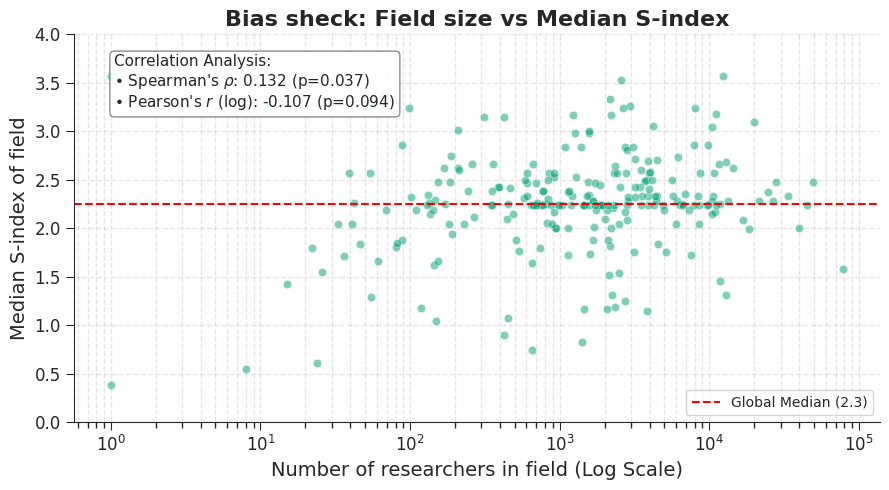

In [57]:
# Spearman for non-linear relationships
corr_spearman, p_spearman = stats.spearmanr(df_field_bias['field_size'], df_field_bias['median_score'])

# Pearson (Log-Transformed): Checks if there is a linear trend on log-scale plot
corr_pearson, p_pearson = stats.pearsonr(np.log10(df_field_bias['field_size']), df_field_bias['median_score'])

# Setup
plt.figure(figsize=(9, 5))
sns.scatterplot(data=df_field_bias, x='field_size', y='median_score', color=color_palette[0], alpha=0.5)

# Reference line (global median value)
global_median = df_field_bias['median_score'].median()
plt.axhline(global_median, color='red', linestyle='--', label=f'Global Median ({global_median:.1f})')

# Statistics box
stats_text = (
    f"Correlation Analysis:\n"
    f"• Spearman's $\\rho$: {corr_spearman:.3f} (p={p_spearman:.3f})\n"
    f"• Pearson's $r$ (log): {corr_pearson:.3f} (p={p_pearson:.3f})"
)

plt.gca().text(0.05, 0.95, stats_text,
               transform=plt.gca().transAxes,
               fontsize=11,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

# Formatting
plt.xscale('log')
plt.title('Bias sheck: Field size vs Median S-index')
plt.xlabel('Number of researchers in field (Log Scale)')
plt.ylabel('Median S-index of field')
plt.legend(loc='lower right')
plt.grid(True, which="both", ls="--", alpha=0.5)
ax = plt.gca()
ax.set_ylim([0, 4])

plt.tight_layout()
plt.show()

### Combined plot

C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\3575605439.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(wrapped, rotation=75, ha="right", fontsize=9)
C:\Users\BPatel\AppData\Local\Temp\ipykernel_42476\3575605439.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


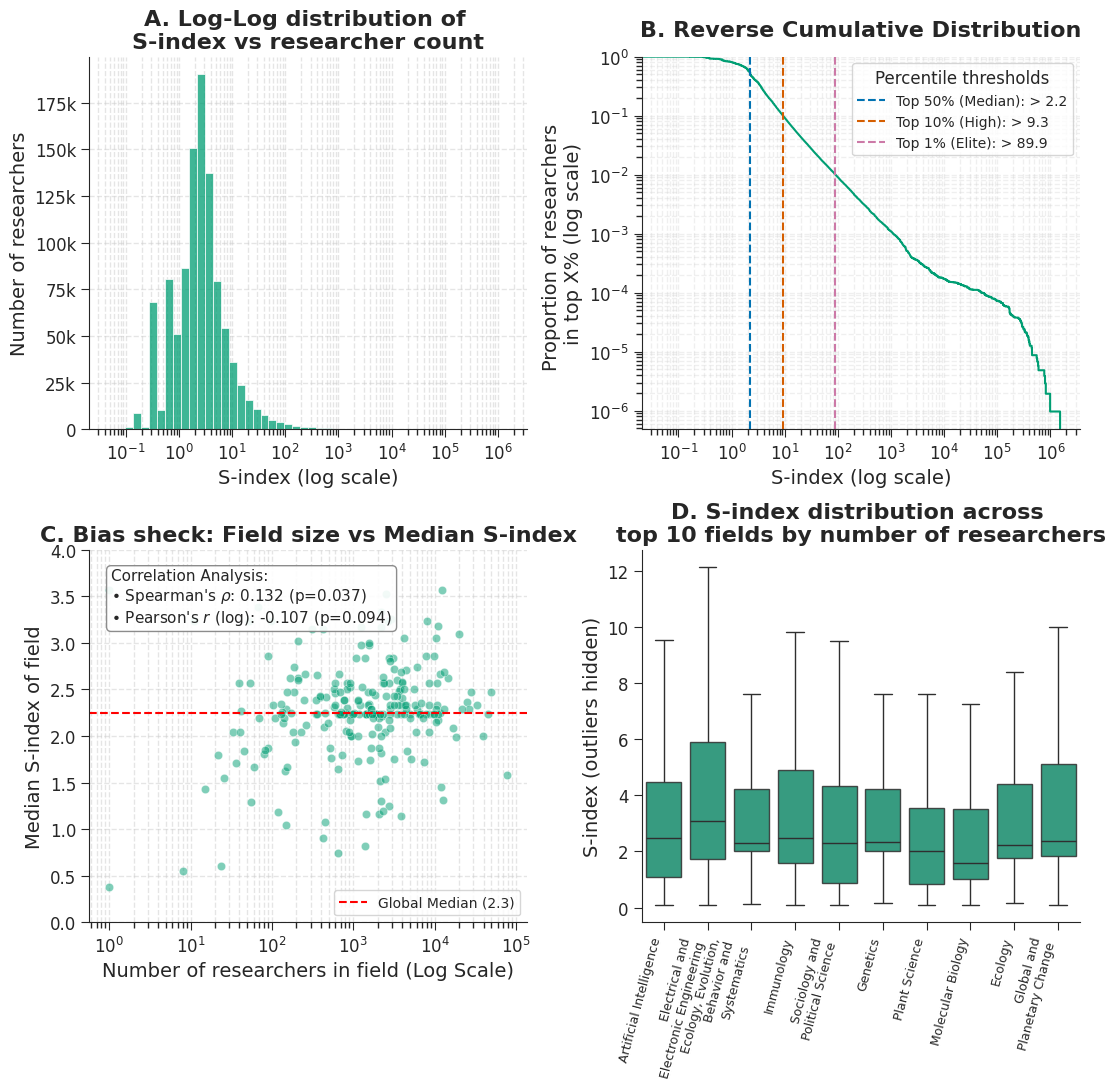

In [58]:
# Figure and Axes
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# TOP LEFT: Log-Log Histogram
ax1 = axes[0, 0]

sns.histplot(
    data=df_sindex, 
    x='S_index_subfield',
    color=color_palette[0],
    log_scale=True,
    bins=50,
    ax=ax1
)


ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useMathText=True)
ax1.set_title('A. Log-Log distribution of \nS-index vs researcher count')
ax1.set_xlabel('S-index (log scale)')
ax1.set_ylabel('Number of researchers')
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_k_m(x)))


# TOP RIGHT: Reverse CDF (Benchmarks)
ax2 = axes[0, 1]

# Percentiles
p50 = df_sindex['S_index_subfield'].quantile(0.50)
p90 = df_sindex['S_index_subfield'].quantile(0.90)
p99 = df_sindex['S_index_subfield'].quantile(0.99)

# Reverse CDF (1 - ECDF)
sns.ecdfplot(
    data=df_sindex, 
    x='S_index_subfield', 
    color=color_palette[0], 
    complementary=True, 
    ax=ax2
)

# Set log scale
ax2.set_yscale('log')
ax2.set_xscale('log')

# Add reference lines 
ax2.axvline(p50, color=color_palette[1], linestyle='--', label=f'Top 50% (Median): > {p50:.1f}')
ax2.axvline(p90, color=color_palette[2], linestyle='--', label=f'Top 10% (High): > {p90:.1f}')
ax2.axvline(p99, color=color_palette[5], linestyle='--', label=f'Top 1% (Elite): > {p99:.1f}')

# Formatting
ax2.set_title('B. Reverse Cumulative Distribution', pad=15)
ax2.set_xlabel('S-index (log scale)')
ax2.set_ylabel('Proportion of researchers \nin top X% (log scale)')
ax2.legend(title='Percentile thresholds')
ax2.grid(True, which="both", ls="--", alpha=0.3)

# BOTTOM LEFT: Bias Check (Scatter)
ax3 = axes[1, 0]

# Spearman & Pearson calculations
corr_spearman, p_spearman = stats.spearmanr(df_field_bias['field_size'], df_field_bias['median_score'])
corr_pearson, p_pearson = stats.pearsonr(np.log10(df_field_bias['field_size']), df_field_bias['median_score'])

sns.scatterplot(
    data=df_field_bias, 
    x='field_size', 
    y='median_score', 
    color=color_palette[0], 
    alpha=0.5, 
    ax=ax3
)

# Reference global median
global_median = df_field_bias['median_score'].median()
ax3.axhline(global_median, color='red', linestyle='--', label=f'Global Median ({global_median:.1f})')

# Statistics box
stats_text = (
    f"Correlation Analysis:\n"
    f"• Spearman's $\\rho$: {corr_spearman:.3f} (p={p_spearman:.3f})\n"
    f"• Pearson's $r$ (log): {corr_pearson:.3f} (p={p_pearson:.3f})"
)

ax3.text(0.05, 0.95, stats_text,
         transform=ax3.transAxes,
         fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

# Formatting
ax3.set_xscale('log')
ax3.set_title('C. Bias sheck: Field size vs Median S-index')
ax3.set_xlabel('Number of researchers in field (Log Scale)')
ax3.set_ylabel('Median S-index of field')
ax3.legend(loc='lower right')
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.set_ylim([0, 4])

# BOTTOM RIGHT: Box plot top fields
ax4 = axes[1, 1]

top_subfields = df_sindex['primary_subfield_name'].value_counts().head(10).index
df_subset = df_sindex[df_sindex['primary_subfield_name'].isin(top_subfields)]

sns.boxplot(
    data=df_subset, 
    x='primary_subfield_name', 
    y='S_index_subfield', 
    color=color_palette[0], 
    boxprops=dict(alpha=0.85),
    showfliers=False,
    ax=ax4
)

# Formatting
ax4.set_title('D. S-index distribution across \ntop 10 fields by number of researchers')
ax4.set_ylabel('S-index (outliers hidden)')
ax4.set_xlabel('')

# Wrapped labels x
def wrap_after_n_words(s, n=2):
    words = str(s).split()
    return "\n".join(" ".join(words[i:i+n]) for i in range(0, len(words), n))

labels = [t.get_text() for t in ax4.get_xticklabels()]
wrapped = [wrap_after_n_words(l, n=2) for l in labels]
ax4.set_xticklabels(wrapped, rotation=75, ha="right", fontsize=9)

plt.tight_layout()
plt.savefig('output/combined_sindex.png', dpi=300, format='png')
plt.show()

### Focus on Ophtalmology

In [59]:
con = duckdb.connect(dataset_db)
df_ophthalmology = con.execute("""
    SELECT*
    FROM s_index_clean 
    WHERE primary_subfield_id = 2731
    LIMIT 3
""").df()
display(df_ophthalmology)
con.close()

,distinct_group_id,grouping_method,display_name,primary_identifier,all_affiliations,name_type,primary_topic_id,primary_topic_name,primary_subfield_id,primary_subfield_name,...,n_datasets,S_index_topics,S_index_subfield,avg_dataset_index_topics,avg_dataset_index_subfield,total_cit_weight,total_men_weight,sum_total_citations,sum_total_mentions,avg_fair_score
0,0000-0001-9143-9657,identifier,"Leonard, Don",0000-0001-9143-9657,[The Ohio State University],Personal,T12523,Nasolacrimal Duct Obstruction Treatments,2731,Ophthalmology,...,941,605.72,612.67,0.64,0.65,0.00,0.00,0.00,0.00,27.59
1,0000-0002-2502-3669,identifier,"Pulit, Sara L",0000-0002-2502-3669,"[Oxford University, University Medical Center ...",Personal,T11194,Ocular Diseases and Behçet’s Syndrome,2731,Ophthalmology,...,50,116.66,126.08,2.33,2.52,25.42,147.90,16.00,97.00,62.54
2,"cárdenas, paco_[uppsala university]",name_affiliation,"Cárdenas, Paco",NaN,[Uppsala University],Personal,T12523,Nasolacrimal Duct Obstruction Treatments,2731,Ophthalmology,...,2,40.54,40.54,20.27,20.27,119.62,0.00,98.00,0.00,13.46


In [60]:
con = duckdb.connect(dataset_db)
query = """
SELECT 
    COUNT(*) as researcher_count
FROM s_index_clean
WHERE primary_subfield_id = 2731
"""
display(con.execute(query).df())
con.close()

,researcher_count
0,591


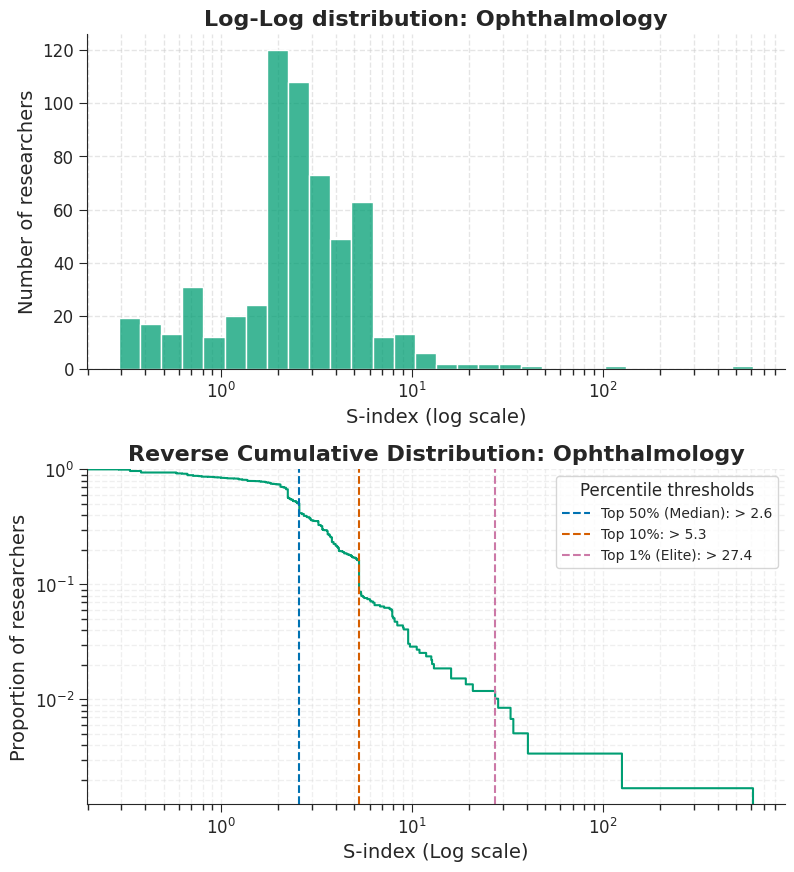

In [61]:
con = duckdb.connect(dataset_db)
query = """
SELECT 
    S_index_subfield,
    primary_subfield_name
FROM s_index_clean
WHERE primary_subfield_id = 2731
"""
df_subfield = con.execute(query).df()
con.close()

# Get the name for the title
if not df_subfield.empty:
    subfield_name = df_subfield['primary_subfield_name'].iloc[0]
else:
    subfield_name = "Subfield 2731"
    print("No name found for this subfield.")

# Setup
fig, axes = plt.subplots(2, 1, figsize=(9, 10))
plt.subplots_adjust(hspace=0.3)
color_palette = sns.color_palette()

# TOP PLOT: Log-Log Histogram
ax1 = axes[0]

sns.histplot(
    data=df_subfield, 
    x='S_index_subfield',
    color=color_palette[0],
    log_scale=True,
    bins=30,
    ax=ax1
)

#ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useMathText=True)

ax1.set_title(f'Log-Log distribution: {subfield_name}')
ax1.set_xlabel('S-index (log scale)')
ax1.set_ylabel('Number of researchers')
ax1.grid(True, which="both", ls="--", alpha=0.5)

# BOTTOM PLOT: Reverse CDF
ax2 = axes[1]

# Calculate Percentiles specific to this subfield
p50 = df_subfield['S_index_subfield'].quantile(0.50)
p90 = df_subfield['S_index_subfield'].quantile(0.90)
p99 = df_subfield['S_index_subfield'].quantile(0.99)

# Reverse CDF
sns.ecdfplot(
    data=df_subfield, 
    x='S_index_subfield', 
    color=color_palette[0], 
    complementary=True, 
    ax=ax2
)

ax2.set_xscale('log')
ax2.set_yscale('log')

# Reference Lines
ax2.axvline(p50, color=color_palette[1], linestyle='--', label=f'Top 50% (Median): > {p50:.1f}')
ax2.axvline(p90, color=color_palette[2], linestyle='--', label=f'Top 10%: > {p90:.1f}')
ax2.axvline(p99, color=color_palette[5], linestyle='--', label=f'Top 1% (Elite): > {p99:.1f}')

ax2.set_title(f'Reverse Cumulative Distribution: {subfield_name}')
ax2.set_xlabel('S-index (Log scale)')
ax2.set_ylabel('Proportion of researchers')
ax2.legend(title='Percentile thresholds')
ax2.grid(True, which="both", ls="--", alpha=0.3)

plt.savefig('output/ophthalmology.png', dpi=300, format='png')
plt.show()